In [1]:
import numpy as np
import sympy as smp
import matplotlib.pyplot as plt

# Elasticidad 1D

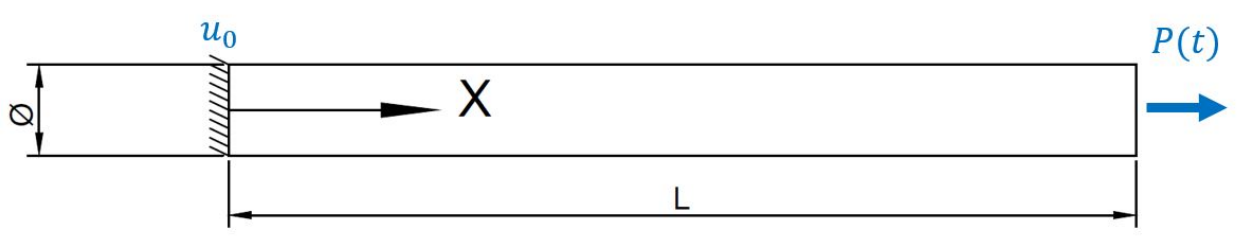

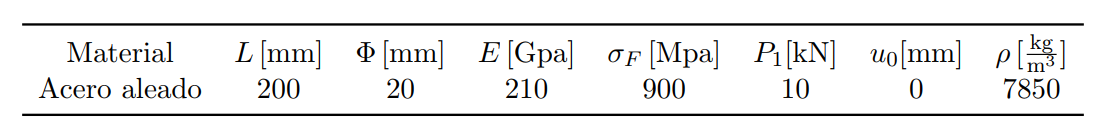

## 1 - Carga constante $P_1$ en $t = 0$

En primer lugar se realiza un análisis estático a modo de obtener los datos necesarios para luego resolver el transitorio. Resultan de interés las matrices de rigidez y masa y el vector de fuerzas o cargas externas, para lo cual se desarrolla un código MEF 1D.

Se definen las variables globales que describen al problema de elasticidad en cuestión, homogeneizando unidades para trabajar en milímetros:

In [2]:
# Variables globales
L = 200 # [mm]
diam = 20 # [mm]
E = 210000 # [N/mm2]
A = (np.pi*diam**2)/4 # [mm2]
P1 = 10000 # [N]
rho = 7.850e-9 # [Tn/mm3]

Para la discretización de la barra, se sigue la recomendación del enunciado y se utilizan elementos de 2 nodos. 

La distribución de los mismos podría ser homogénea (nodos equiespaciados generados directamente con la función `np.linspace`, por ejemplo) pero suele ser una buena práctica adoptar un refinamiento hacia al extremo libre de la barra para satisfacer de forma más aproximada la condición de borde natural o de Neumann. Vale aclarar que en este caso en particular, al haber una carga puntual en el extremo se esperan desplazamientos que varían linealmente a lo largo de la misma y, en consecuencia, una tensión constante. Esto hace que no tenga mucho sentido el refinamiento pero, con el fin didáctico de aplicar los conceptos vistos en el curso, se lo realizará igualmente. 

Se define entonces una función que genera los nodos de la siguiente manera: para la viga de 200 mm, el 10% de los nodos se encuentran entre 0 y 50 mm, el 20% entre 50 y 100 mm, el 30% entre 100 y 150 mm y el 40% restante entre 150 y 200 mm. Si bien esta distribución es arbitraria y se trata de un problema 1D sencillo en términos de condiciones de borde y cargas, se vio en trabajos previos que puede ser beneficioso y se aplica el concepto para este análisis.

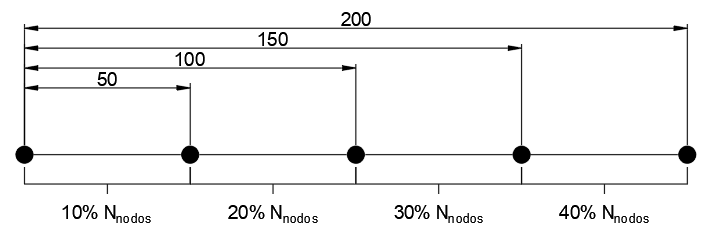

In [3]:
def generar_nodos(num_nodos):
    nodos_a = np.linspace(0, 50, int(num_nodos*0.1), endpoint=False)
    nodos_b = np.linspace(50, 100, int(num_nodos*0.2), endpoint=False)
    nodos_c = np.linspace(100, 150, int(num_nodos*0.3), endpoint=False)
    nodos_d = np.linspace(150, 200, int(num_nodos*0.4 + 1))
    nodos = np.concatenate((nodos_a, nodos_b, nodos_c, nodos_d))
    return nodos.reshape(-1, 1)

También se define de antemano una función que permita ensamblar las matrices de rigidez, masa y los vectores de carga (aunque dadas las condiciones de este problema este último es trivial). La función simplemente genera un vector que numera los nodos de acuerdo sus coordenadas globales y se utiliza para referir los índices con los que trabaja el código (coordenadas locales) a las posiciones de los nodos.

Otra definición previa es un vector que contiene las funciones de interpolación:

$$h_1(r) = \frac{1}{2} \, (1 - r)$$

$$h_2(r) = \frac{1}{2} \, (1 + r)$$

In [4]:
def generar_matriz_conectividad(n):
    conect = np.array([[i, i+1] for i in range(1, n+1)])
    return conect

def H(r):
    return np.array([[0.5 * (1 - r), 0.5 * (1 + r)]])


Derivándolas se obtiene $\underline{\underline{Hr}}$. Esta matriz junto con el jacobiano (que en este caso varía dada la distribución no homogénea de nodos) permite obtener las matrices de rigidez locales $\underline{\underline{K_L}}$. Se ve entonces que de plantear una distribución uniforme de nodos el jacobiano se podría calcular una sola vez y el costo computacional se reduciría mientras que con el método adoptado se debe calcular tantas veces como cambios en la distribución haya. Dado que en problemas unidimensionales $J^{(e)}$ termina siendo un escalar, el costo computacional no resulta tan problemático por lo que se acepta el compromiso que implica refinar la cantidad de nodos hacia el extremo derecho. Cabe aclarar que, para no complejizar el código, el jacobiano se calcula en cada elemento, incluso aunque se sepa que no va a cambiar de uno a otro. Esto le aporta flexibilidad al programa en caso de cambiar el refinamiento y, de nuevo, para la cantidad de elementos que se van a utilizar no implica problemas de esfuerzo de cálculo.

    h1r = -0.5
    h2r = 0.5
    Hr = np.array([[h1r, h2r]])

Con el jacobiano $J^{(e)}$ y $\underline{\underline{Hr}}$ se obtiene la matriz $\underline{\underline{B}}$:

$$
\underline{\underline{B}}^{(e)} = \left | J \right |^{(e)^{-1}} \cdot \underline{\underline{Hr}}
$$


    J = pos_nodos[i]*Hr[0, 0] + pos_nodos[i+1]*Hr[0, 1]
    B = (1/J)*Hr

Las matrices de rigidez locales $\underline{\underline{K_L}}$ se obtienen entonces como:

$$\underline{\underline{K_L}}^{(e)} = \int_{-1}^{1} {B^{(e)}}^T\cdot E \cdot B^{(e)} \cdot A \cdot J^{(e)} \, \mathrm{d}r$$

Cada una de las matrices de 2x2 halladas se almacenan en una matriz tridimensional `KL_global` a la cual se accederá luego para realizar el ensamble.

    KL = B.T*E*B*A*J*2
    KL_global[i] = KL

La matriz de masas $\underline{\underline{M^{(e)}}}$ se calcula de la siguiente manera:

$$
\underline{\underline{M}}^{(e)} = \int_{-1}^{1} \int_{-1}^{1} \int_{-1}^{1} {H^{(e)}}^T \cdot \rho \cdot H^{(e)} \cdot A \cdot \left | J \right |^{(e)} \, \mathrm{d}r \, \mathrm{d}s \, \mathrm{d}t
$$

En este caso, dado que el problema es unidimensional con densidad y sección transversal constante se puede simplificar a la expresión:

$$
\underline{\underline{M}}^{(e)} = \rho \, A \, \int_{-1}^{1} {H^{(e)}}^T \cdot H^{(e)} \cdot \left | J \right |^{(e)} \, \mathrm{d}r
$$

Respecto al vector de cargas $\underline{R}^{(e)}$, será nulo para todos los puntos menos para el extremo derecho porque no hay cargas externas actuando en la barra (como podría ser una fuerza distribuida a lo largo de la misma, por ejemplo). Se lo define como nulo para todos los elementos por completitud y luego en el análisis de las condiciones de borde se incorpora la carga externa.

Para la integración se utiliza el método de Gauss o cuadratura gaussiana. En el caso de la matriz de rigidez local basta con un solo punto de Gauss pero para la matriz de masas el producto ${H^{(e)}}^T \cdot H^{(e)}$ hace que aparezcan términos de segundo grado y sea necesario integrar mediante 2 puntos de Gauss (de ahí el índice `j` que corresponde al loop `for` para la integración).

    for j in range (len(PGauss)):
        matriz_M_global[i] += OmegaG[j]*rho*A*H(PGauss[j]).T*H(PGauss[j])*J

Para el ensamble se recoren las filas y columnas de las matrices globales ya inicializadas y se asignan los valores de los elementos mediante índices referidos a la matriz de conectividades definida antes:
    
    # Ensamble K y M
        for k in range(0, len(PGauss)):
            for l in range(0, len(PGauss)):
                KG[conect[i, k]-1, conect[i, l]-1] += KL_global[i, k, l]
                MG[conect[i, k]-1, conect[i, l]-1] += matriz_M_global[i, k, l]
    # Ensamble R
            RG[conect[i, k]-1, 0] += RL_global[i, k, 0]

Una vez ensambladas las matrices, se aplican las condiciones de borde. En este caso se trata de simplemente agregar la fuerza $P_1$ al último nodo, en el extremo libre de la barra.

    RG[len(pos_nodos)-1, 0] += P1

Además, se fuerza la condición de desplazamiento nulo en el empotramiento haciendo unitario el primer elemento de la matriz de rigidez ${K_G}_{1,1}$ y anulando todos los demás valores de la primera fila y columna. Lo mismo se hace para la matriz $\underline{\underline{M_G}}$ debido a que en el transitorio la ecuación a resolver será:

$$
\underline{\underline{M_G}} \cdot \ddot{\hat{\underline{\textrm{U}}}} + \underline{\underline{C}} \cdot \dot{\hat{\underline{\textrm{U}}}} + \underline{\underline{K_G}} \cdot \hat{\underline{\textrm{U}}} = \underline{R}
$$

donde se asume que $\underline{\underline{C}} = \underline{\underline{0}}$ porque no se menciona ningún amortiguamiento en el enunciado. No es necesario anular la carga externa en ese nodo dado que ya es nula conforme a lo planteado en el cálculo de $\underline{R}^{(e)}$. Como el desplazamiento $\hat{\underline{\textrm{U}}}$ es nulo para el primer nodo porque se forzó de esta manera debido al empotramiento y el vector de cargas externas $\underline{R}$ también es nulo en dicho punto, para satisfacer la igualdad se debe forzar a la matriz de masa $\underline{\underline{M_G}}$ a cumplirla de la misma manera que se hizo con la de rigidez $\underline{\underline{K_G}}$.

    KGCB = KG
    KGCB[0,1:], KGCB[1:, 0] = 0, 0
    MGCB = MG
    MGCB[0,1:], MGCB[1:, 0] = 0, 0
    RGCB = RG
    RGCB[0] = 0

Con las matrices ya calculadas y ensambladas se resuelve el sistema:

    u_solucion = np.linalg.solve(KGCB, RGCB)

In [5]:
def MEF_2nodos(pos_nodos):
    conect = generar_matriz_conectividad(len(pos_nodos)-1)

    OmegaG = [1.0, 1.0]

    # Puntos de Gauss
    PGauss = [1.0/np.sqrt(3), -1.0/np.sqrt(3)]

    # Matriz Hr
    h1r = -0.5
    h2r = 0.5
    Hr = np.array([[h1r, h2r]])

    # Inicialización de K y R locales
    KL_global = np.zeros((len(pos_nodos)-1, 2, 2))
    RL_global = np.zeros((len(pos_nodos)-1, 2, 1))
    matriz_M_global = np.zeros((len(pos_nodos)-1, 2, 2))

    # Inicialización de K, R y M globales
    KG = np.zeros((len(pos_nodos), len(pos_nodos)))
    MG = np.zeros((len(pos_nodos), len(pos_nodos)))
    RG = np.zeros((len(pos_nodos), 1))

    for i in range(len(pos_nodos)-1):
        J = pos_nodos[i]*Hr[0, 0] + pos_nodos[i+1]*Hr[0, 1]
        B = (1/J)*Hr
        KL = B.T*E*B*A*J*2
        KL_global[i] = KL
        RL = 0
        RL_global[i] = RL
        for j in range (len(PGauss)):
            matriz_M_global[i] += OmegaG[j]*rho*A*H(PGauss[j]).T*H(PGauss[j])*J

    # Ensamble K y M
        for k in range(0, len(PGauss)):
            for l in range(0, len(PGauss)):
                KG[conect[i, k]-1, conect[i, l]-1] += KL_global[i, k, l]
                MG[conect[i, k]-1, conect[i, l]-1] += matriz_M_global[i, k, l]
    # Ensamble R
            RG[conect[i, k]-1, 0] += RL_global[i, k, 0]
    
    # Condiciones de borde
    RG[len(pos_nodos)-1, 0] += P1
    KGCB = KG
    KGCB[0,1:], KGCB[1:, 0] = 0, 0
    MGCB = MG
    MGCB[0,1:], MGCB[1:, 0] = 0, 0
    RGCB = RG
    RGCB[0] = 0
    u_solucion = np.linalg.solve(KGCB, RGCB)
    return u_solucion, KGCB, RGCB, MGCB

Se pueden plotear los resultados de los desplazamientos para distinta cantidad de elementos para determinar la cantidad a utilizar en el análisis transitorio.

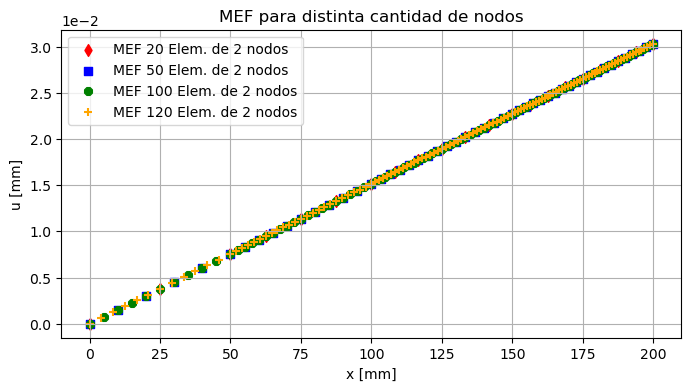

In [6]:
plt.figure(figsize=(8,4))

plt.scatter(generar_nodos(20), MEF_2nodos(generar_nodos(20))[0], label='MEF 20 Elem. de 2 nodos', marker='d', c='r')
plt.scatter(generar_nodos(50), MEF_2nodos(generar_nodos(50))[0], label='MEF 50 Elem. de 2 nodos', marker='s', c='b')
# plt.scatter(generar_nodos(80), MEF_2nodos(generar_nodos(80))[0], label='MEF 80 Elem. de 2 nodos', marker='x', c='g')
plt.scatter(generar_nodos(100), MEF_2nodos(generar_nodos(100))[0], label='MEF 100 Elem. de 2 nodos', marker='8', c='g')
plt.scatter(generar_nodos(120), MEF_2nodos(generar_nodos(120))[0], label='MEF 120 Elem. de 2 nodos', marker='+', c='orange')

plt.title('MEF para distinta cantidad de nodos')
plt.xlabel('x [mm]')
plt.ylabel('u [mm]')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid(True)
plt.legend()
plt.show()

Los resultados son esperables dada la sencillez del problema. Si bien el análisis estático no es necesariamente determinante para definir la cantidad de elementos óptima para analizar un caso transitorio, viene bien para observar (y notar que no tiene demasiado sentido para este problema) el refinamiento de los nodos y tener una idea cualitativa de la convergencia de la solución. 

Se opta por seguir la recomendación del enunciado y realizar el análisis con <u>100 elementos</u> de aquí en adelante.

Se corre el programa anterior y se guardan los datos necesarios en las siguientes variables:

In [7]:
resultados_MEF = MEF_2nodos(generar_nodos(100))
cant_nodos = len(resultados_MEF[0])

### Método explícito

Este tipo de métodos tienen la particularidad de que no requieren invertir la matriz de rigidez pero están restringidos en el intervalo temporal $\Delta t$ que pueden tomar para no perder la estabilidad y diverger. El objetivo es desarrollar un código que converja sin tener que disminuir excesivamente el paso.

#### Datos de entrada

Según se mencionó previamente, la ecuación a resolver es

$$
\underline{\underline{M}} \cdot \ddot{\hat{\underline{\textrm{U}}}} + \underline{\underline{C}} \cdot \dot{\hat{\underline{\textrm{U}}}} + \underline{\underline{K}} \cdot \hat{\underline{\textrm{U}}} = \underline{R}
$$

Las matrices de masa $\underline{\underline{M}}$ y rigidez $\underline{\underline{K}}$ y el vector de cargas externas $\underline{R}$ se obtienen del código MEF. Como también se aclaró, se consdiera que el problema no está amortiguado por lo que $\underline{\underline{C}}$ se asume nula pero se incluye en el código por completitud.

    # Matriz de masa, amortiguación y rigidez
    M = resultados_MEF[3]
    C = np.zeros(M.shape)
    K = resultados_MEF[1]

    # Matriz de cargas externas
    R = resultados_MEF[2]

Los desplazamientos en el instante inicial son nulos ya que por enunciado se considera la barra incialmente descargada. Lo mismo ocurre para las velocidades.

$$\dot{\hat{\underline{\textrm{U}}}} = \underline{0}$$

$${\underline{\textrm{U}}} = \underline{0}$$

Las aceleraciones de los nodos no serán nulas en el inicio ya que la barra se encuentra sometida a una fuerza externa y, si bien la misma se encuentra empotrada, internamente debe equilibrarse el efecto de la acción que actúa sobre el sólido. Se puede despejar entonces de la ecuación de equilibrio dinámico:

$$\underline{\underline{M}} \cdot ^{0} \! \ddot{\hat{\underline{\textrm{U}}}} + \underline{\underline{K}} \cdot ^{0} \! \hat{\underline{\textrm{U}}} = \underline{R}$$

$$\underline{\underline{M}} \cdot ^{0} \! \ddot{\hat{\underline{\textrm{U}}}} + \underline{\underline{K}} \cdot \underset{0}{\underbrace{^{0} \hat{\underline{\textrm{U}}}}}\ = \underline{R}$$

$$^{0}  \ddot{\hat{\underline{\textrm{U}}}}  = \underline{\underline{M}}^{-1} \cdot \underline{R}$$

    # Condiciones inciales
    U_0 = np.zeros((cant_nodos,1))
    U_0_punto = np.zeros((cant_nodos,1))
    U_0_2puntos = np.linalg.inv(M)@R

#### Paso temporal $\Delta t$

Para determinar el paso temporal se debe calcular primero el valor crítico, es decir, el valor máximo del paso para garantizar estabilidad. Si se supera, la solución diverge. Este valor crítico se calcula como:

$$\Delta t \leq \frac{2}{\omega_{max}} $$

donde $\omega_{max}$ es la máxima frecuencia natural de vibración. Dicha frecuencia se podría obtener mediante un análisis de vibraciones pero, como excede el alcance de este trabajo, se planteará un método alternativo. 

Se decide estimar la máxima frecuencia según propone Bathe en su libro *Finite Element Procedures*: utilizando la transformada de Fourier. La estrategia adoptada es realizar el análisis por el método de Newmark, que es estable para cualquier paso temporal y transformar la solución hallada para los desplazamientos en el extremo de la barra. De esta manera, se grafica en el dominio de frecuencias y se determina el pico máximo de la función. El inconveniente es que la precisión no es demasiado buena y, desarrollando el método de diferencias centrales definiendo al paso directamente como el valor hallado gráficamente, el código tiene un error de *overflow* (diverge). Por este motivo se opta por multiplicarlo por un factor de $1,3$ que surge de ir probando arbitrariamente factores de corrección hasta que el código funcione, también da una idea del error en el procedimiento aplicado.

La obtención gráfica de este valor se ilustrará posteriormente en el desarrollo a modo de mantener el orden de resolución propuesto por el enunciado.

El $\Delta t_{crít}$ obtenido resulta ser:

$$\Delta t_{crít} = \frac{2}{\omega_{max}} = \frac{2}{11269245.72 \, rad/s}$$

$$\Delta t_{crít} = 1,77 \times 10^{-7} \, s = 0,177 \, \mu s$$

Dado que no hay amortiguamiento, el desplazamiento del paso temporal próximo $^{t+\Delta t}\underline{\hat{U}}$ se calcula como:

$$
^{t+\Delta t}\underline{\hat{U}} = \left [ \frac{1}{\Delta t^2} \, \underline{\underline{M}} \right ]^{-1}  \cdot \left \{ ^{t}R - \left[ \underline{\underline{K}} - \frac{2}{\Delta t^2} \, \underline{\underline{M}} \right ] \cdot  \  ^{t}\underline{\hat{U}} - \left [\frac{1}{\Delta t^2} \, \underline{\underline{M}} \right ] \cdot \  ^{t-\Delta t}\underline{\hat{U}} \right \}
$$

El término 

$$\left [ \frac{1}{\Delta t^2} \, \underline{\underline{M}} \right ] ^{-1}$$

se invierte una sola vez por mantenerse constante para ahorrar costo computacional y evitando invertir en cada paso temporal. De todas formas se trata de una operación bastante sencilla.

    termino_inv2 = np.linalg.inv((1/deltaTDC1**2)*M + 1/(2*deltaTDC1)*C)

Otra particularidad es que se debe calcular un paso previo $^{t-\Delta t}\underline{\hat{U}}$, incluso en la primera iteración. Se puede deducir que en el primer paso:

$$
^{t-\Delta t}\underline{\hat{U}} = \ ^{0}\underline{\hat{U}} - \Delta t \ ^{0}\underline{\dot{\hat{U}}} + \frac{\Delta t^2}{2} \ ^{0}\underline{\ddot{\hat{U}}}
$$

    resultadosUDC[0] = U_0 - deltaTDC1*U_0_punto + (deltaTDC1**2/2)*U_0_2puntos

Luego se recorre el bucle `for` para calcular todos los pasos temporales:

    for i in range (1, cant_pasosDC+1):
        resultadosUDC[i+1] = termino_inv2 @ (R - (K - (2/deltaTDC1**2)*M)@resultadosUDC[i] - \
                                            ((1/deltaTDC1**2)*M - (1/(2*deltaTDC1)*C))@resultadosUDC[i-1])

En este caso no hace falta calcular ni velocidades ni aceleraciones.                                    

In [8]:
# Matriz de masa, amortiguación y rigidez
M = resultados_MEF[3]
C = np.zeros(M.shape)
K = resultados_MEF[1]

# Matriz de cargas externas
R = resultados_MEF[2]

# Condiciones inciales
U_0 = np.zeros((cant_nodos,1))
U_0_punto = np.zeros((cant_nodos,1))
U_0_2puntos = np.linalg.inv(M)@R

Se define entonces la función `MDC(paso temporal)` que aplica el método explícito de diferencias centrales para los datos de entrada obtenidos con el código MEF desarrollado. El parámetro a ingresar será el paso temporal a considerar.

In [9]:
def MDC(deltaTDC):
    # deltaTDC1 = 2/(10681367.21*1.35)
    t_finDC = 50e-3
    cant_pasosDC = int(t_finDC/deltaTDC)
    paso_tempDC = np.array([i*deltaTDC - deltaTDC for i in range(cant_pasosDC+2)])

    resultadosUDC = np.zeros((cant_pasosDC+2, cant_nodos, 1))
    resultadosU2pDC = np.zeros((cant_pasosDC+1, cant_nodos, 1))
    resultadosU2pDC[0] = U_0_2puntos
    resultadosU1pDC = np.zeros((cant_pasosDC+1, cant_nodos, 1))

    resultadosUDC[0] = U_0 - deltaTDC*U_0_punto + (deltaTDC**2/2)*U_0_2puntos
    termino_inv2 = np.linalg.inv((1/deltaTDC**2)*M + 1/(2*deltaTDC)*C)

    for i in range (1, cant_pasosDC+1):
        resultadosUDC[i+1] = termino_inv2 @ (R - (K - (2/deltaTDC**2)*M)@resultadosUDC[i] - \
                                            ((1/deltaTDC**2)*M - (1/(2*deltaTDC)*C))@resultadosUDC[i-1])
        # resultadosU2pDC[i+1] = 1/deltaT**2 * (resultadosUDC[i+1] - 2*resultadosUDC[i] + resultadosUDC[i-1])
        # resultadosU1pDC[i+1] = 1/(2*deltaT) * (resultadosUDC[i+1] - resultadosUDC[i-1])
    return resultadosUDC, paso_tempDC

Se ejecuta el código para los datos de entrada desarrollados previamente:

In [10]:
deltaTDC1 = 2/(11269245.72*1.30)
resultadosDC1 = MDC(deltaTDC1)
desplazDC1 = resultadosDC1[0]
tiemposDC1 = resultadosDC1[1]

Los resultados se grafican en 3D donde un eje es la coordenada $x$, otro el desplazamiento $u(x, t)$ y el tercero el tiempo $t$.

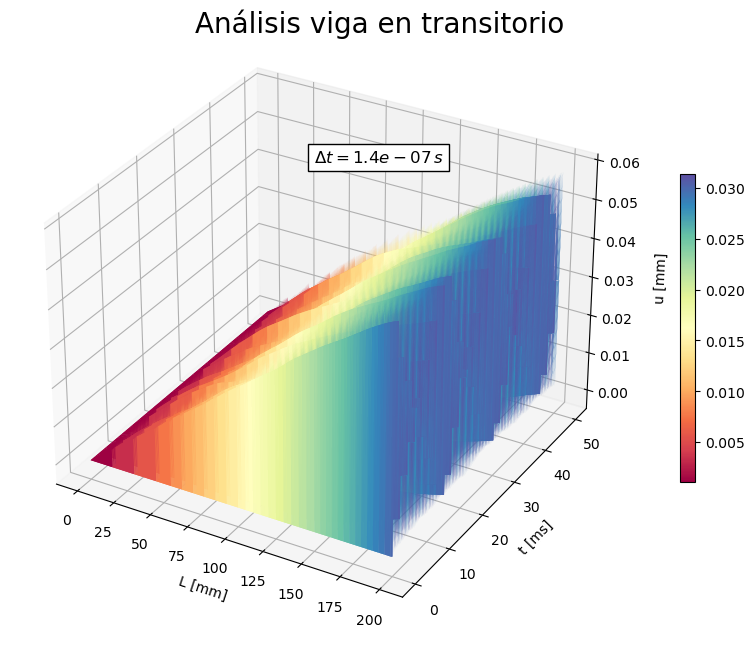

In [11]:
X = generar_nodos(cant_nodos)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')

# Graficar la superficie
X_grid, Y_grid = np.meshgrid(X, tiemposDC1*1000)
ax.plot_surface(X_grid, Y_grid, desplazDC1[:, :, 0], cmap='Spectral', edgecolor='none')

# Título y ejes
plt.title('Análisis viga en transitorio', fontsize=20, x=0.6, y=1.05)
ax.set_xlabel('L [mm]')
ax.set_ylabel('t [ms]')
ax.set_zlabel('\nu [mm]', linespacing=2)
ax.text(150, 0, 0.09, f'$\\Delta t = {deltaTDC1:.2g} \,  s$', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

# Barra de color
plt.colorbar(ax.plot_surface(X_grid, Y_grid, desplazDC1[:, :, 0], cmap='Spectral', edgecolor='none'), shrink = 0.5)
plt.subplots_adjust(right=1.2) 

plt.show()

Si se observa el extremo libre de la barra se aprecia la periodicidad en las vibraciones. Nótese que se grafican 5 ms. La razón de considerar un periodo más corto para este análisis es que dada la alta frecuencia de vibración, no se llegan a apreciar visualmente las oscilaciones.

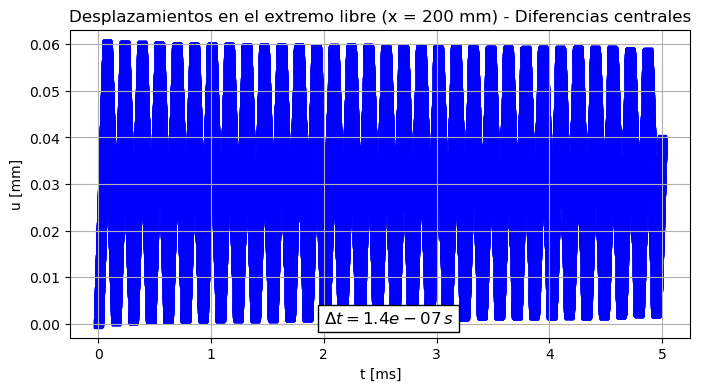

In [12]:
plt.figure(figsize=(8,4))

plt.scatter(tiemposDC1[:int(5e-3/deltaTDC1)]*1000, desplazDC1[:int(5e-3/deltaTDC1), -1, 0], marker='s', c='b')

plt.text(2, 0, f'$\\Delta t = {deltaTDC1:.2g} \,  s$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
plt.title('Desplazamientos en el extremo libre (x = 200 mm) - Diferencias centrales')
plt.xlabel('t [ms]')
plt.ylabel('u [mm]')
plt.grid(True)
plt.show()

#### Aumento de 10 veces en el paso temporal

Se vuelve a ejectuar el mismo código para exactamente 10 veces el paso temporal. Es de esperarse que los resultados no converjan ya que en el caso anterior ya había apenas un 35% aproximadamente de diferencia respecto al paso crítico $\Delta t_{cr}$.

In [13]:
deltaTDC2 = deltaTDC1*10
resultadosDC2 = MDC(deltaTDC2)
desplazDC2 = resultadosDC2[0]
tiemposDC2 = resultadosDC2[1]

C:\Users\Ema\AppData\Local\Temp\ipykernel_26844\265990815.py:16: RuntimeWarning: overflow encountered in matmul
  resultadosUDC[i+1] = termino_inv2 @ (R - (K - (2/deltaTDC**2)*M)@resultadosUDC[i] - \
C:\Users\Ema\AppData\Local\Temp\ipykernel_26844\265990815.py:16: RuntimeWarning: invalid value encountered in matmul
  resultadosUDC[i+1] = termino_inv2 @ (R - (K - (2/deltaTDC**2)*M)@resultadosUDC[i] - \
C:\Users\Ema\AppData\Local\Temp\ipykernel_26844\265990815.py:17: RuntimeWarning: invalid value encountered in matmul
  ((1/deltaTDC**2)*M - (1/(2*deltaTDC)*C))@resultadosUDC[i-1])


Si bien el código no da error y se ejecuta, ya se obtienen advertencias de *overflow* y valores no válidos. 

El gráfico 3D ni siquiera es capaz de mostrar los resultados.

c:\Users\Ema\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Ema\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:180: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


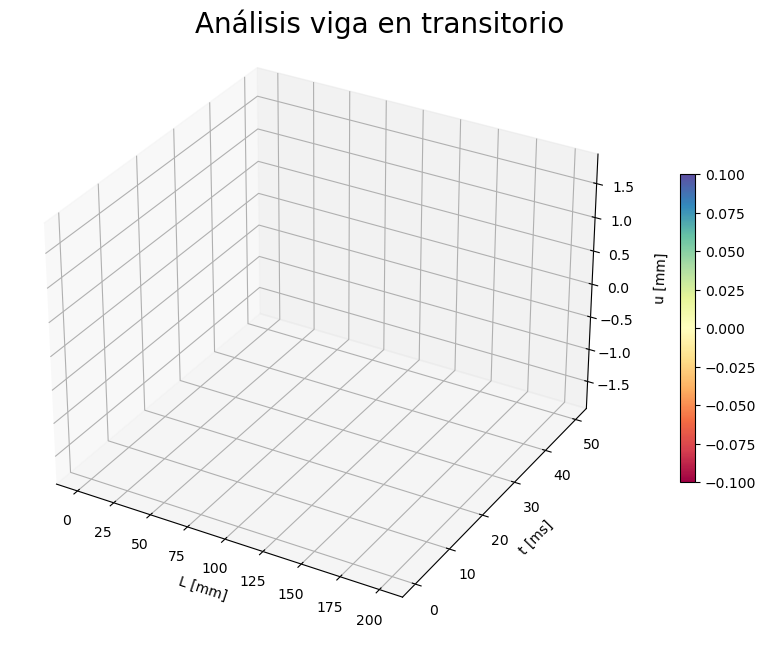

In [14]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')

# Graficar la superficie
X_grid, Y_grid = np.meshgrid(X, tiemposDC2*1000)
ax.plot_surface(X_grid, Y_grid, desplazDC2[:, :, 0], cmap='Spectral', edgecolor='none')

# Título y ejes
plt.title('Análisis viga en transitorio', fontsize=20, x=0.6, y=1.05)
ax.set_xlabel('L [mm]')
ax.set_ylabel('t [ms]')
ax.set_zlabel('\nu [mm]', linespacing=2)

# Barra de color
plt.colorbar(ax.plot_surface(X_grid, Y_grid, desplazDC2[:, :, 0], cmap='Spectral', edgecolor='none'), shrink = 0.5)
plt.subplots_adjust(right=1.2) 

plt.show()

Graficando el extremo de la barra se ven desplazamientos del orden de $10^{300} \, mm$ a los 0.15 ms. Esto parece indicar que es en este paso temporal donde el código comienza a fallar.

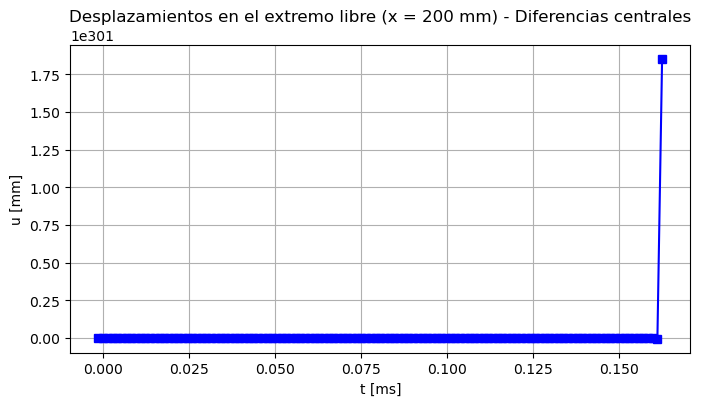

In [15]:
plt.figure(figsize=(8,4))

plt.plot(tiemposDC2[:int(5e-3/deltaTDC2)]*1000, desplazDC2[:int(5e-3/deltaTDC2), -1, 0], marker='s', c='b')

plt.title('Desplazamientos en el extremo libre (x = 200 mm) - Diferencias centrales')
plt.xlabel('t [ms]')
plt.ylabel('u [mm]')
plt.grid(True)
plt.show()

Se verifica entonces que el paso temporal elegido inicialmente está en el orden de magnitud del paso crítico, por lo que para que haya convergencia no se podrá aumentar mucho más. Se podría decir entonces que el costo computacional que implica el paso elegido no está demasiado lejos del valor mínimo posible que garantiza estabilidad.

### Método implícito

A continuación se desarrolla el código que resuelve los desplazamientos para un périodo de tiempo dado utilizando el método de Newmark. La característica distintiva del método es que, con los parámetros adecuados, es incondicionalmente estable. Esto quiere decir que converge sin restricciones para el valor del paso temporal.

Las condiciones iniciales y datos de entrada son las mismas que para el método explícito por tratarse del mismo problema. En este caso se incorporan algunas variables adicionales.

#### Parámetros del método de Newmark

Se definen las constantes $\delta$ y $\alpha$ requeridas por el método. Para lograr que sea incondicionalmente estable se establecen en 0.5 y 0.25 respectivamente.

$$\alpha = 0,25 \hspace{5pt} ; \hspace{5pt} \delta = 0,5$$

    # Constantes del método
    delta = 0.5
    alpha = 0.25

El paso temporal óptimo se podría determinar haciendo un análisis de frecuencias que excede al alcance de este trabajo por lo que simplemente se plantearán distintos valores y se analizará cómo varía la solución. Luego se verificará qué pasa al aumentarlo exactamente 10 veces. En todos los casos se simularán 50 ms según indica el enunciado.

El método de Newmark, en casos sin amortiguamiento, propone calcular los desplazamientos para cada paso temporal de la siguiente manera:

$$
^{t+\Delta t}\underline{\hat{U}} = \left [ \frac{1}{\Delta t^2 \, \alpha} \, \underline{\underline{M}} + \underline{\underline{K}} \right ]^{-1}  \cdot \left \{ ^{t + \Delta t}R + \underline{\underline{M}} \left[\frac{1}{\Delta t^2 \, \alpha} \  ^{t}\underline{\hat{U}} +\frac{1}{\Delta t \, \alpha} \  ^{t}\underline{\dot{\hat{U}}} + \left ( \frac{1}{2 \, \alpha} -1 \right ) \  ^{t}\underline{\ddot{\hat{U}}} \right ] \right \}
$$

En este caso se debe invertir un término que incluye también la matriz de rigidez. Tal inversión requiere un costo computacional mayor a la que se necesita en el método explícito. No obstante, dado que las matrices en cuestión se mantienen constantes, se puede realizar la inversión una sola vez y luego ingresar al bucle:

    # Inversión de matrices
    termino_inv = np.linalg.inv(((1/(deltaTNM**2*alpha))*M + (delta/(alpha*deltaTNM))*C + K))

Aquí también se incluye el factor de amortiguamiento por completitud pero se lo trata como una matriz nula.

Otra diferencia es la necesidad de calcular las aceleraciones y velocidades puesto que son necesarias para hallar el próximo desplazamiento. Esto también agrega costo computacional respecto al método previo. Las ecuaciones son:

$$
^{t + \Delta t}\underline{\ddot{\hat{U}}} = \frac{1}{\Delta t^2 \, \alpha} \left[ ^{t +\Delta t}\underline{\hat{U}} - ^{t}\underline{\hat{U}} - \Delta t \ ^{t}\underline{\dot{\hat{U}}} \right] - \left( \frac{1}{2}-\alpha \right) \, \frac{1}{\alpha} \ ^{t}\underline{\ddot{\hat{U}}}
$$

$$
^{t + \Delta t}\underline{\dot{\hat{U}}} = \ ^{t}\underline{\dot{\hat{U}}} + \left[ \left (1-\delta \right) \  ^{t}\underline{\ddot{\hat{U}}} + \delta \, \ ^{t + \Delta t}\underline{\ddot{\hat{U}}} \right] \Delta t
$$

Las 3 ecuaciones se calculan en el bucle `for`:

    for i in range (cant_pasos):
        # Desplazamientos
        resultadosUNM[i+1] = termino_inv @ (R + M@((1/(deltaTNM**2*alpha))*resultadosUNM[i] +
                                            (1/(deltaTNM*alpha))*resultadosU1pNM[i] + (1/(2*alpha) - 1)*resultadosU2pNM[i] +
                                            C@((delta/(alpha*deltaTNM))*resultadosUNM[i] + (delta/alpha - 1)*resultadosUNM[i] +
                                            (deltaTNM/2)*(delta/alpha - 2)*resultadosU2pNM[i])))
        
        # Aceleraciones
        resultadosU2pNM[i+1] = (1/(deltaTNM**2 * alpha)) * (resultadosUNM[i+1] - resultadosUNM[i] - deltaTNM * resultadosU1pNM[i]) \
        - (0.5 - alpha) * (1/alpha) * resultadosU2pNM[i]

        # Velocidades
        resultadosU1pNM[i+1] = resultadosU1pNM[i] + ((1 - delta)*resultadosU2pNM[i] + delta*resultadosU2pNM[i+1])*deltaTNM

Como comentario adicional, se define la función con los parámetros `deltaTNM` para poder ingresar el paso temporal, `t_fin` para definir el tiempo total a calcular y `carga` para modificar el vector $\underline{\underline{R}}$ de acuerdo a lo que se pide en el punto 2.

In [16]:
def P2(t):
    return P1*np.sin(2*np.pi*130*t)

def MNM(deltaTNM, t_fin, carga):
    R = resultados_MEF[2]
    # Constantes del método
    delta = 0.5
    alpha = 0.25

    # Intervalo temporal
    # deltaTNM = 1.5947e-7 # [s]
    cant_pasos = int(t_fin/deltaTNM)

    # Inicialización de vectores
    resultadosUNM = np.zeros((cant_pasos+1, cant_nodos, 1))
    resultadosU2pNM = np.zeros((cant_pasos+1, cant_nodos, 1))
    resultadosU2pNM[0] = U_0_2puntos
    resultadosU1pNM = np.zeros((cant_pasos+1, cant_nodos, 1))

    paso_tempNM = np.zeros(cant_pasos+1)

    # Inversión de matrices
    termino_inv = np.linalg.inv(((1/(deltaTNM**2*alpha))*M + (delta/(alpha*deltaTNM))*C + K))

    for i in range (cant_pasos):
        # Paso temporal
        paso_tempNM[i+1] = (i+1)*deltaTNM
        
        if carga == 2:
            R[-1] = P2(paso_tempNM[i+1])

        # Desplazamientos
        resultadosUNM[i+1] = termino_inv @ (R + M@((1/(deltaTNM**2*alpha))*resultadosUNM[i] +
                                            (1/(deltaTNM*alpha))*resultadosU1pNM[i] + (1/(2*alpha) - 1)*resultadosU2pNM[i] +
                                            C@((delta/(alpha*deltaTNM))*resultadosUNM[i] + (delta/alpha - 1)*resultadosUNM[i] +
                                            (deltaTNM/2)*(delta/alpha - 2)*resultadosU2pNM[i])))
        
        # Aceleraciones
        resultadosU2pNM[i+1] = (1/(deltaTNM**2 * alpha)) * (resultadosUNM[i+1] - resultadosUNM[i] - deltaTNM * resultadosU1pNM[i]) \
        - (0.5 - alpha) * (1/alpha) * resultadosU2pNM[i]

        # Velocidades
        resultadosU1pNM[i+1] = resultadosU1pNM[i] + ((1 - delta)*resultadosU2pNM[i] + delta*resultadosU2pNM[i+1])*deltaTNM
    return resultadosUNM, paso_tempNM

Dado que cualquier paso temporal converge, se proponen distintos valores con el objetivo de graficar las vibraciones y realizar un análisis cualitativo de su comportamiento. A modo demostrativo, se puede comenzar con un paso de 1 ms:

In [17]:
deltaTNM1 = 1e-3
resultadosNM1 = MNM(deltaTNM1, 50e-3, 0)
desplazNM1 = resultadosNM1[0]
tiemposNM1 = resultadosNM1[1]

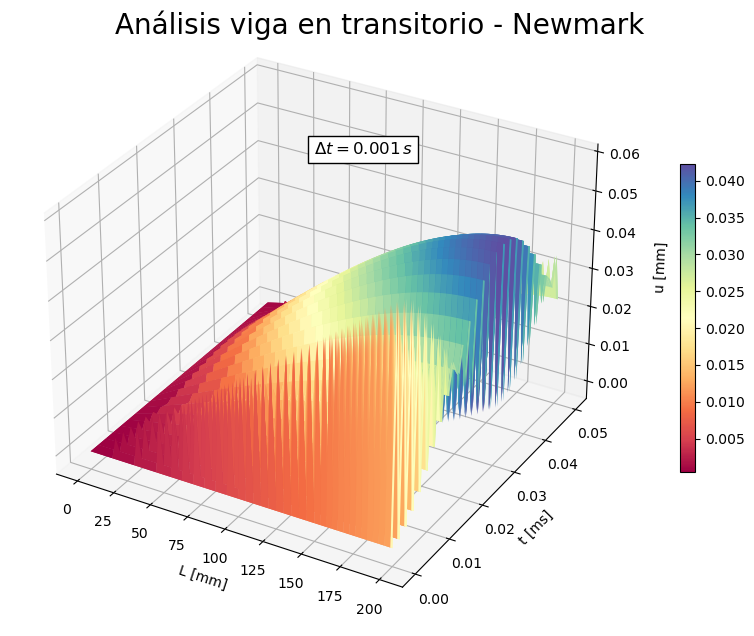

In [18]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')

# Graficar la superficie
X_grid, Y_grid = np.meshgrid(X, tiemposNM1)
ax.plot_surface(X_grid, Y_grid, desplazNM1[:, :, 0], cmap='Spectral', edgecolor='none')

# Título y ejes
plt.title('Análisis viga en transitorio - Newmark', fontsize=20, x=0.6, y=1.03)
ax.set_xlabel('L [mm]')
ax.set_ylabel('t [ms]')
ax.set_zlabel('\nu [mm]', linespacing=2)

ax.text(150, 0, 0.09, f'$\\Delta t = {deltaTNM1:.2g} \,  s$', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

# Barra de color
plt.colorbar(ax.plot_surface(X_grid, Y_grid, desplazNM1[:, :, 0], cmap='Spectral', edgecolor='none'), shrink = 0.5)
plt.subplots_adjust(right=1.2)

plt.show()

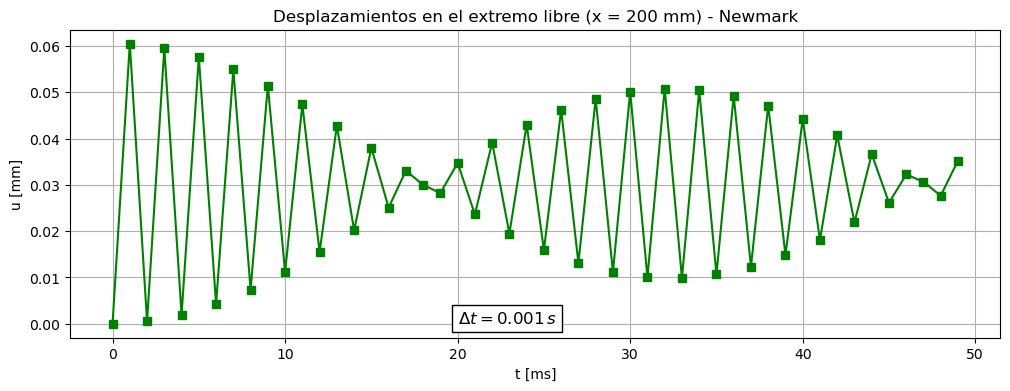

In [19]:
plt.figure(figsize=(12,4))

plt.plot(tiemposNM1[:int(50e-3/deltaTNM1)]*1000, desplazNM1[:int(50e-3/deltaTNM1), -1, 0], marker='s', c='g')

plt.title('Desplazamientos en el extremo libre (x = 200 mm) - Newmark')
plt.xlabel('t [ms]')
plt.ylabel('u [mm]')
plt.grid(True)
plt.text(20, 0, f'$\\Delta t = {deltaTNM1:.2g} \,  s$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.show()

Se ve que, si bien el método no diverge y representa una función periódica como se espera (y se vio en el método explícito), la amplitud varía notablemente a lo largo del tiempo. Se necesita entonces un paso temporal $\Delta t$ más pequeño.

In [20]:
deltaTNM2 = 1e-5
resultadosNM2 = MNM(deltaTNM2, 50e-3, 0)
desplazNM2 = resultadosNM2[0]
tiemposNM2 = resultadosNM2[1]

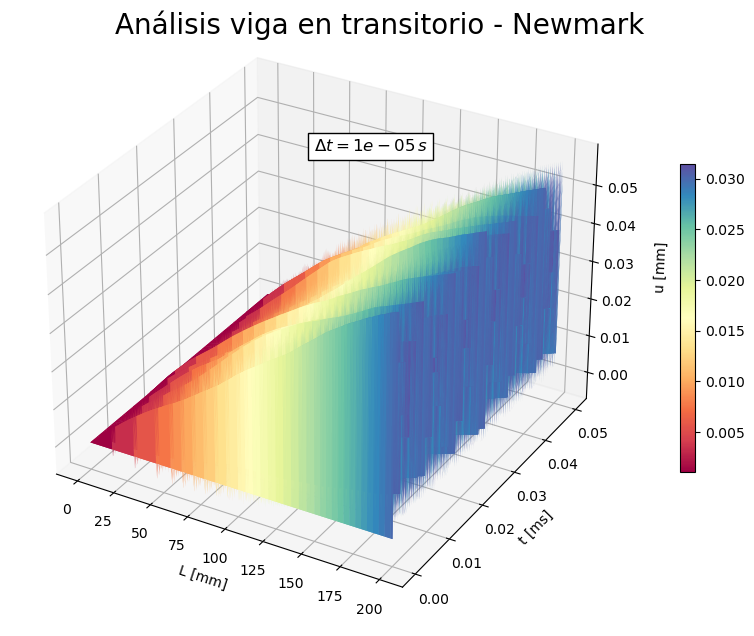

In [21]:
X = generar_nodos(cant_nodos)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')

# Graficar la superficie
X_grid, Y_grid = np.meshgrid(X, tiemposNM2)
ax.plot_surface(X_grid, Y_grid, desplazNM2[:, :, 0], cmap='Spectral', edgecolor='none')

# Título y ejes
plt.title('Análisis viga en transitorio - Newmark', fontsize=20, x=0.6, y=1.03)
ax.set_xlabel('L [mm]')
ax.set_ylabel('t [ms]')
ax.set_zlabel('\nu [mm]', linespacing=2)

ax.text(150, 0, 0.09, f'$\\Delta t = {deltaTNM2:.2g} \,  s$', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

# Barra de color
plt.colorbar(ax.plot_surface(X_grid, Y_grid, desplazNM2[:, :, 0], cmap='Spectral', edgecolor='none'), shrink = 0.5)
plt.subplots_adjust(right=1.2)

plt.show()

Con un paso de $10  \, \mu s$ ya la solución empieza a tomar una forma similar a la obtenida con el método explícito. La cantidad de puntos hace que representar los 50 ms se dificulte por cuestiones gráficas, entonces se muestra qué ocurre en los primeros 5 ms:

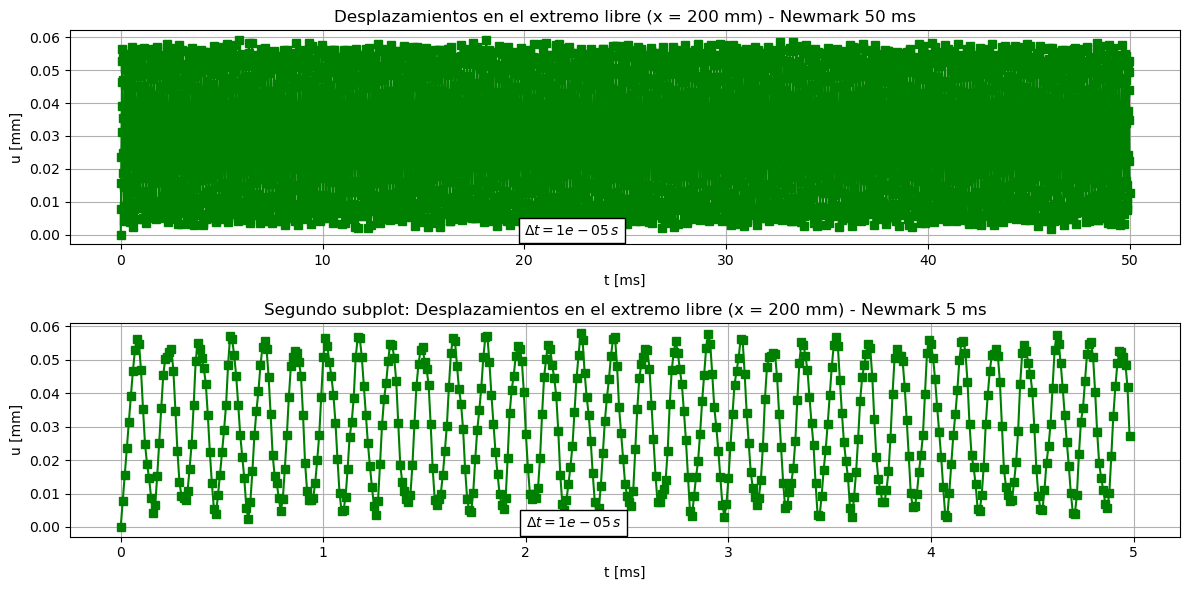

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))  # Dos filas, una columna

# Graficar en ambos subplots
axs[0].plot(tiemposNM2[:int(50e-3/deltaTNM2)]*1000, desplazNM2[:int(50e-3/deltaTNM2), -1, 0], marker='s', c='g')
axs[1].plot(tiemposNM2[:int(5e-3/deltaTNM2)]*1000, desplazNM2[:int(5e-3/deltaTNM2), -1, 0], marker='s', c='g')

# Configurar títulos y etiquetas
for ax in axs:
    ax.set_xlabel('t [ms]')
    ax.set_ylabel('u [mm]')
    ax.grid(True)

axs[0].text(20, 0, f'$\\Delta t = {deltaTNM2:.2g} \,  s$', bbox=dict(facecolor='white', edgecolor='black'))
axs[1].text(2, 0, f'$\\Delta t = {deltaTNM2:.2g} \,  s$', bbox=dict(facecolor='white', edgecolor='black'))
axs[0].set_title('Desplazamientos en el extremo libre (x = 200 mm) - Newmark 50 ms')
axs[1].set_title('Segundo subplot: Desplazamientos en el extremo libre (x = 200 mm) - Newmark 5 ms')

plt.tight_layout()


# Mostrar los subplots
plt.show()

A diferencia del método explícito, con un paso de 2 órdenes de magnitud mayor ($~ 10^{-5}$ contra $~10^{-7}$ s) ya la solución converge y muestra un caracter senoidal. Se analiza ahora qué pasa si se lo aumenta 10 veces, a $1 \times 10^{-4}$ s (0,1 ms).

In [23]:
deltaTNM3 = 1e-4
resultadosNM3 = MNM(deltaTNM3, 50e-3, 0)
desplazNM3 = resultadosNM3[0]
tiemposNM3 = resultadosNM3[1]

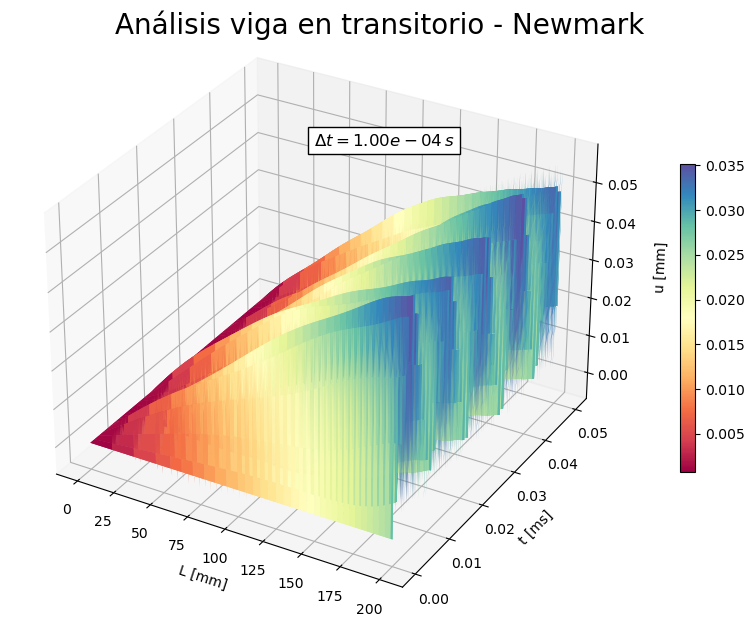

In [24]:
X = generar_nodos(cant_nodos)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')

# Graficar la superficie
X_grid, Y_grid = np.meshgrid(X, tiemposNM3)
ax.plot_surface(X_grid, Y_grid, desplazNM3[:, :, 0], cmap='Spectral', edgecolor='none')

# Título y ejes
plt.title('Análisis viga en transitorio - Newmark', fontsize=20, x=0.6, y=1.03)
ax.set_xlabel('L [mm]')
ax.set_ylabel('t [ms]')
ax.set_zlabel('\nu [mm]', linespacing=2)

ax.text(150, 0, 0.09, f'$\\Delta t = {deltaTNM3:.2e} \,  s$', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

# Barra de color
plt.colorbar(ax.plot_surface(X_grid, Y_grid, desplazNM3[:, :, 0], cmap='Spectral', edgecolor='none'), shrink = 0.5)
plt.subplots_adjust(right=1.2)

plt.show()

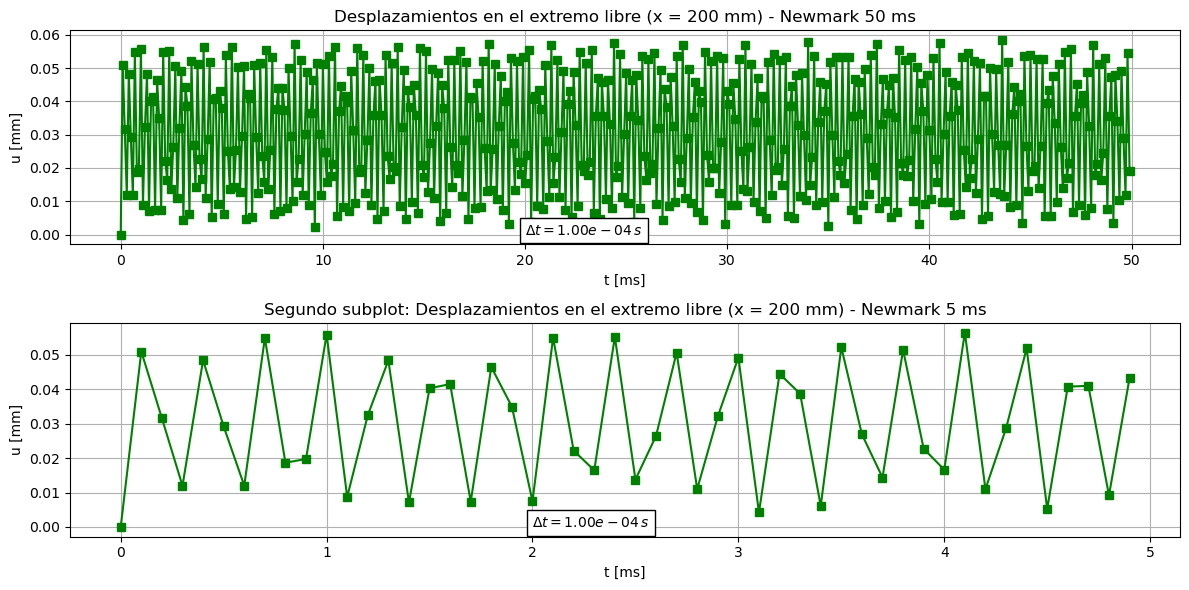

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))  # Dos filas, una columna

# Graficar en ambos subplots
axs[0].plot(tiemposNM3[:int(50e-3/deltaTNM3)]*1000, desplazNM3[:int(50e-3/deltaTNM3), -1, 0], marker='s', c='g')
axs[1].plot(tiemposNM3[:int(5e-3/deltaTNM3)]*1000, desplazNM3[:int(5e-3/deltaTNM3), -1, 0], marker='s', c='g')

# Configurar títulos y etiquetas
for ax in axs:
    ax.set_xlabel('t [ms]')
    ax.set_ylabel('u [mm]')
    ax.grid(True)

axs[0].text(20, 0, f'$\\Delta t = {deltaTNM3:.2e} \,  s$', bbox=dict(facecolor='white', edgecolor='black'))
axs[1].text(2, 0, f'$\\Delta t = {deltaTNM3:.2e} \,  s$', bbox=dict(facecolor='white', edgecolor='black'))
axs[0].set_title('Desplazamientos en el extremo libre (x = 200 mm) - Newmark 50 ms')
axs[1].set_title('Segundo subplot: Desplazamientos en el extremo libre (x = 200 mm) - Newmark 5 ms')

plt.tight_layout()


# Mostrar los subplots
plt.show()

Al igual que los casos anteriores, la solución converge. La diferencia radica en cómo se representa la senoidal: al haber menos puntos la tasa de muestreo no es lo suficientemente grande para relevar la onda y se produce una especie de *aliasing*, análogo a lo que ocurre en el ámbito de las señales electrónicas.

### Comparativa entre métodos

Se compara para el paso temporal utilizando en el método explícito la solución obtenida por ambos métodos:

In [26]:
resultadosNMcomp = MNM(deltaTDC1, 50e-3, 0)
desplazNMcomp = resultadosNMcomp[0]
tiemposNMcomp = resultadosNMcomp[1]

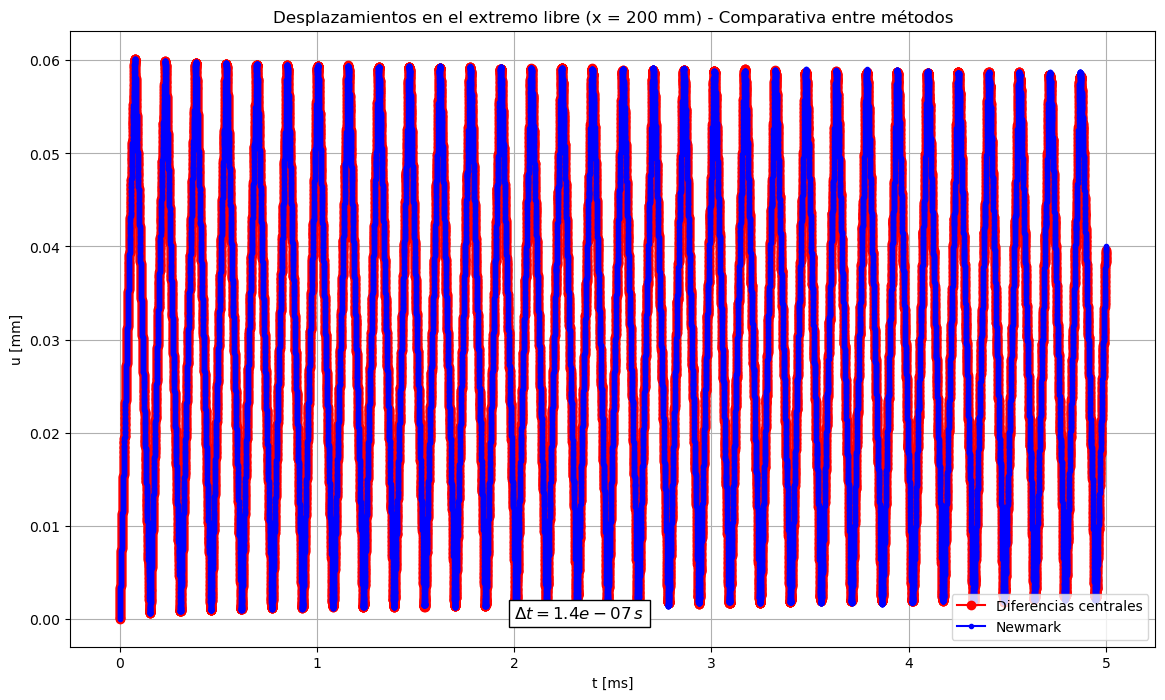

In [27]:
plt.figure(figsize=(14,8))

plt.plot(tiemposDC1[:int(5e-3/deltaTDC1)]*1000, desplazDC1[:int(5e-3/deltaTDC1), -1, 0], marker='o', c='r', label='Diferencias centrales')
plt.plot(tiemposNMcomp[:int(5e-3/deltaTDC1)]*1000, desplazNMcomp[:int(5e-3/deltaTDC1), -1, 0], marker='.', c='b', label='Newmark')

plt.text(2, 0, f'$\\Delta t = {deltaTDC1:.2g} \,  s$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
plt.title('Desplazamientos en el extremo libre (x = 200 mm) - Comparativa entre métodos')
plt.xlabel('t [ms]')
plt.ylabel('u [mm]')
plt.legend()
plt.grid(True)
plt.show()

Se ve que la solución es prácticamente la misma para ambos métodos.


#### Obtención aproximada del tiempo crítico para el método explícito

Una vez analizado el método de Newmark, se ilustra la obtención del tiempo crítico mencionada en apartados previos. La estrategia adoptada es correr el método de implícito con un paso tal que represente con claridad la vibración de la barra, esto es, analizar el gráfico y ver una amplitud constante y una senoidal claramente marcada, con puntos en todos sus valles y crestas. Con la señal ya definida, se aplica la transformada de Fourier para hacer un análisis de frecuencias y así determinar la máxima: $\omega_{máx}$.

Se observa que con un paso de $1 \, \mu s$ (que sigue siendo un orden más grande que el utilizado en el método explícito), se obtienen desplazamientos con los cuales se puede proceder con el análisis de frecuencias:

In [28]:
deltaTNM4 = 1.39e-7
resultadosNM4 = MNM(deltaTNM4, 50e-3, 0)
desplazNM4 = resultadosNM4[0]
tiemposNM4 = resultadosNM4[1]

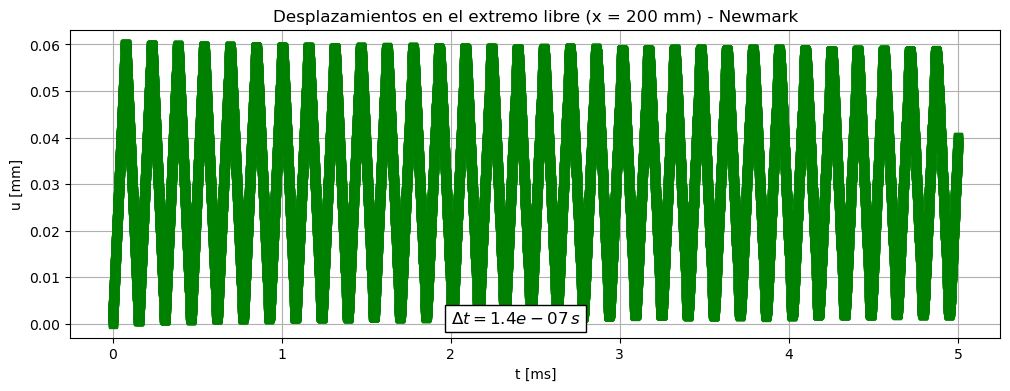

In [29]:
plt.figure(figsize=(12,4))

plt.plot(tiemposNM4[:int(5e-3/deltaTNM4)]*1000, desplazNM4[:int(5e-3/deltaTNM4), -1, 0], marker='s', c='g')

plt.title('Desplazamientos en el extremo libre (x = 200 mm) - Newmark')
plt.xlabel('t [ms]')
plt.ylabel('u [mm]')
plt.grid(True)
plt.text(2, 0, f'$\\Delta t = {deltaTNM4:.2g} \,  s$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.show()

Con los datos anteriores para los 50 ms de simulación (que no se muestran porque no se llega a apreciar la función), se aplica la Transformada Discreta de Fourier. Se trata de una herramienta útil para analizar datos discretos, como los desplazamientos en el extremo de la barra en cuestión.

La misma se define mediante una serie discreta $x_t$ medida en un intervalo finito de tiempo. La definición formal es

$$\hat{x}(f_n) = \sum_{k=0}^{N-1} x_t e^{-2 \pi i f_n (k \Delta t)} \hspace{10mm} f_n=\frac{n}{N\Delta t}$$

donde $f_n$ son las llamdas frecuencias de Fourier. 

Con las ecuaciones anteriores, se puede simplificar a

$$\hat{x}_n = \sum_{k=0}^{N-1} x_t e^{-2 \pi i kn/N}$$

De todas formas, los fundamentos matemáticos que entran en juego exceden lo pretendido en este trabajo.

Las siguientes líneas de código aplican esta función a los datos calculados y permiten graficarlos:

    T = 50e-3 # [s]
    t = tiemposNM4
    dt = np.diff(t)[0]
    N = int(T/dt)
    u_ext = desplazNM4[:, -1, 0]

    # Transformada de Fourier
    transformada_F = np.fft.fft(u_ext)
    amplitud = np.abs(transformada_F)/len(u_ext)
    amplitud_graf = amplitud[1:N//2]

    # Frecuencias de muestra
    frec_F = np.fft.fftfreq(len(t), dt)
    f_pos_rads = 2*np.pi*frec_F[1:N//2]

A modo de ejemplo, se pueden hallar las primeras 3 frecuencias naturales:

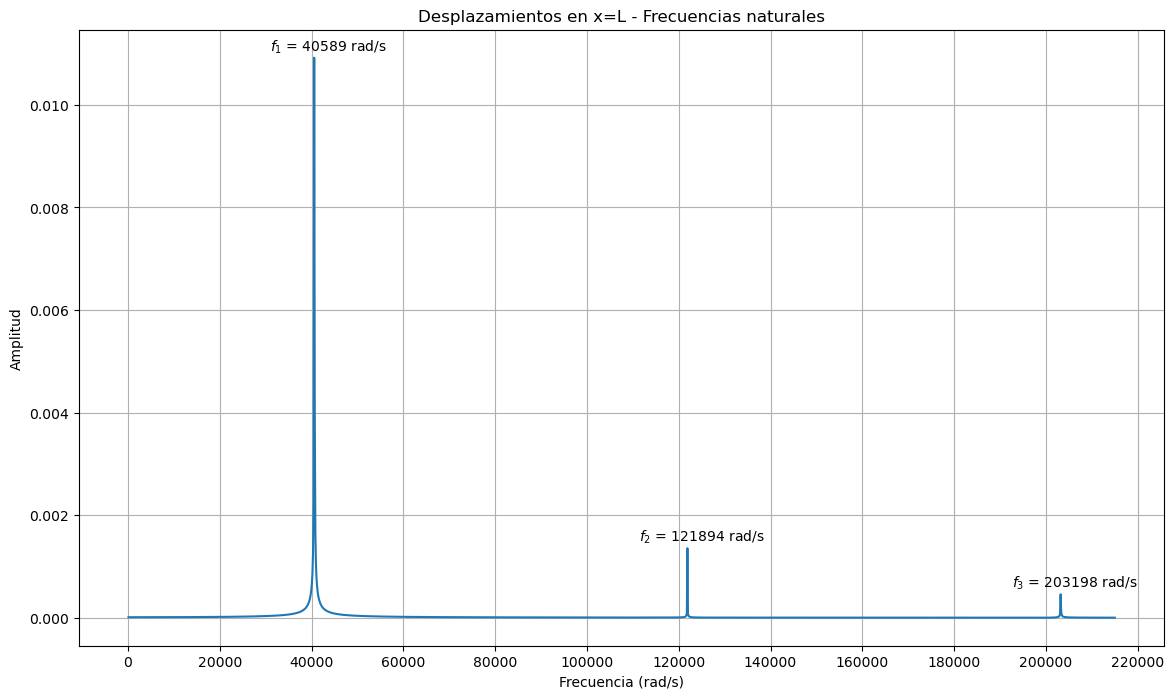

In [30]:
import matplotlib.ticker as ticker

T = 50e-3 # [s]
t = tiemposNM4
dt = np.diff(t)[0]
N = int(T/dt)
u_ext = desplazNM4[:, -1, 0]

# Transformada de Fourier
transformada_F = np.fft.fft(u_ext)
amplitud = np.abs(transformada_F)/len(u_ext)
amplitud_graf = amplitud[1:N//210]

# Frecuencias de muestra
frec_F = np.fft.fftfreq(len(t), dt)
f_pos_rads = 2*np.pi*frec_F[1:N//210]

# Graficar el espectro de frecuencias
plt.figure(figsize=(14, 8))
plt.plot(f_pos_rads, amplitud_graf)
plt.xlabel("Frecuencia (rad/s)")
plt.ylabel("Amplitud")
plt.title("Desplazamientos en x=L - Frecuencias naturales")
plt.locator_params(axis="x", nbins=20)
def formatear_decimales(x, pos):
    return f"{x:.0f}"

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(formatear_decimales))
plt.grid(True)

rango_f1 = np.where((f_pos_rads >= 30000) & (f_pos_rads <= 45000))
indice_f1 = rango_f1[0][np.argmax(amplitud_graf[rango_f1])]
valor_f1 = f_pos_rads[indice_f1]

rango_f2 = np.where((f_pos_rads >= 120000) & (f_pos_rads <= 130000))
indice_f2 = rango_f2[0][np.argmax(amplitud_graf[rango_f2])]
valor_f2 = f_pos_rads[indice_f2]

rango_f3 = np.where((f_pos_rads >= 200000) & (f_pos_rads <= 210000))
indice_f3 = rango_f3[0][np.argmax(amplitud_graf[rango_f3])]
valor_f3 = f_pos_rads[indice_f3]

plt.annotate(f"$f_1$ = {valor_f1:.0f} rad/s", (valor_f1, amplitud_graf[indice_f1]),
             textcoords="offset points", xytext=(10, 5), ha='center')
plt.annotate(f"$f_2$ = {valor_f2:.0f} rad/s", (valor_f2, amplitud_graf[indice_f2]),
             textcoords="offset points", xytext=(10, 5), ha='center')
plt.annotate(f"$f_3$ = {valor_f3:.0f} rad/s", (valor_f3, amplitud_graf[indice_f3]),
             textcoords="offset points", xytext=(10, 5), ha='center')
plt.show()


Analizando el final del extremo de frecuencias, se puede hallar el argumento (frecuencia) máximo para el último pico de amplitud:

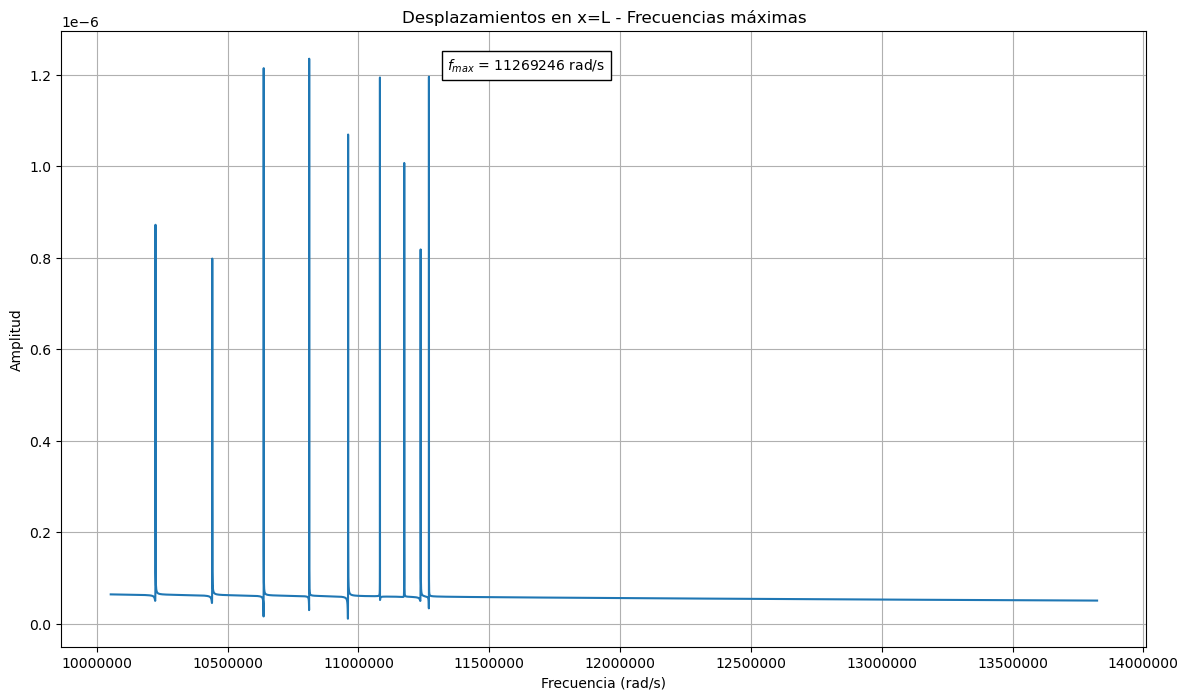

In [31]:
# Calcular la transformada de Fourier
transformada_F = np.fft.fft(u_ext)
amplitud = np.abs(transformada_F)/len(u_ext)
amplitud_graf = amplitud[80000:110000]

# Calcular las frecuencias de muestra correspondientes
frec_F = np.fft.fftfreq(len(t), dt)
f_pos_rads = 2*np.pi*frec_F[80000:110000]

# Graficar el espectro de frecuencias
plt.figure(figsize=(14, 8))
plt.plot(f_pos_rads, amplitud_graf)
plt.xlabel("Frecuencia (rad/s)")
plt.ylabel("Amplitud")
plt.title("Desplazamientos en x=L - Frecuencias máximas")
plt.locator_params(axis="x", nbins=15)
def formatear_decimales(x, pos):
    return f"{x:.0f}"

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(formatear_decimales))
plt.grid(True)

rango_f_max = np.where((f_pos_rads >= 11000000) & (f_pos_rads <= 11500000))
indice_f_max = rango_f_max[0][np.argmax(amplitud_graf[rango_f_max])]
valor_f_max = f_pos_rads[indice_f_max]

plt.annotate(f"$f_{{max}}$ = {valor_f_max:.0f} rad/s", (valor_f_max, amplitud_graf[indice_f_max]),
             textcoords="offset points", xytext=(70, 5), ha='center', bbox=dict(facecolor='white', edgecolor='black'))

plt.show()

De aquí surge entonces la estimación del tiempo crítico realizada en el método explícito, considerando $$\omega_{máx} = 11269245.72 \, rad/s$$

Como análisis adicional, surge la pregunta acerca del paso temporal que hay que tomar para representar los desplazamientos de modo tal que la estimación del $\Delta t_{crít}$ por Fourier tenga un error bajo. Si bien se lo está determinando de una forma más práctica, es decir, con prueba y error, se observa lo siguiente:

Al aumentar el paso temporal la definición de la función es menor y el espectro de frecuencias se achica. Esto da como resultado frecuencias naturales menores que se traducen en $\Delta t_{crít}$ más altos. Como en realidad lo que está ocurriendo es que aumenta el error en la estimación de este parámetro, habrá que aplicar un factor de corrección para la frecuencia (o directamente el paso, según se disponga) todavía más grande. En resumen, habrá que probar más pasos temporales para ver a partir de dónde es que empieza a converger el método.

Se propone analizar la solución por Newmark para un paso de 1 ms:

In [32]:
deltaTNM5 = 1e-6
resultadosNM5 = MNM(deltaTNM5, 50e-3, 0)
desplazNM5 = resultadosNM5[0]
tiemposNM5 = resultadosNM5[1]

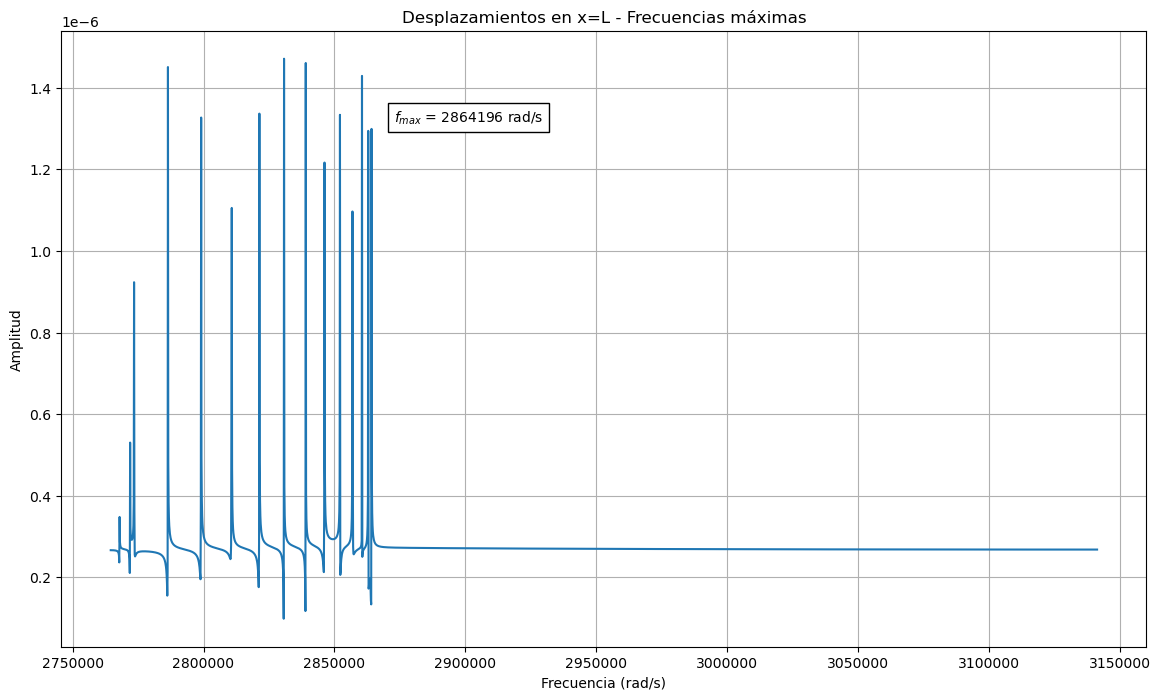

In [33]:
T = 50e-3 # [s]
t = tiemposNM5
dt = np.diff(t)[0]
N = int(T/dt)
u_ext = desplazNM5[:, -1, 0]

# Calcular la transformada de Fourier
transformada_F = np.fft.fft(u_ext)
amplitud = np.abs(transformada_F)/len(u_ext)
amplitud_graf = amplitud[22000:25000]

# Calcular las frecuencias de muestra correspondientes
frec_F = np.fft.fftfreq(len(t), dt)
f_pos_rads = 2*np.pi*frec_F[22000:25000]

# Graficar el espectro de frecuencias
plt.figure(figsize=(14, 8))
plt.plot(f_pos_rads, amplitud_graf)
plt.xlabel("Frecuencia (rad/s)")
plt.ylabel("Amplitud")
plt.title("Desplazamientos en x=L - Frecuencias máximas")
plt.locator_params(axis="x", nbins=15)
def formatear_decimales(x, pos):
    return f"{x:.0f}"

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(formatear_decimales))
plt.grid(True)

rango_f_max = np.where((f_pos_rads >= 2860700) & (f_pos_rads <= 2870000))
indice_f_max = rango_f_max[0][np.argmax(amplitud_graf[rango_f_max])]
valor_f_max = f_pos_rads[indice_f_max]

plt.annotate(f"$f_{{max}}$ = {valor_f_max:.0f} rad/s", (valor_f_max, amplitud_graf[indice_f_max]),
             textcoords="offset points", xytext=(70, 5), ha='center', bbox=dict(facecolor='white', edgecolor='black'))

plt.show()

La frecuencia obtenida es aproximadamente una cuarta parte de la obtenida con un paso 10 veces más pequeño. El $\Delta t_{crít}$ resultaría

$$\Delta t_{crít} = \frac{2}{w_{máx}} = \frac{2}{2864195.57} = 6.98 \times 10^{-7} = 0.698 \, ms$$

Valor aproximadamente 4 veces más grande que el calculado antes.

Tiene sentido, de todas maneras, que el valor a considerar para transformar por Fourier esté cerca del $\Delta t_{crít}$ que se puede estimar por prueba y error. En este caso se determinó de este modo que estaba en el orden de $10^{-7}$ s por lo que es razonable que resolver por Newmark, con este mismo paso, implique valores para el paso crítico con un error menor al 30%.

## 1 - Carga sinusoidal de amplitud $P_1$ en $t = 0$

Para no lidiar con cuestiones de convergencia, se optará por resolver con el método implícito o de Newmark. El código ya fue construido teniendo en cuenta esta consideración por lo que simplemente hay que cambiar sus parámetros de entrada.

La carga tendrá la forma 

$$P = P_1 \, \sin(\omega \, t) = 10 \, kN \, \sin(2 \, \pi \, 130 \, Hz \cdot t)$$

Las líneas de código

    def P2(t):
        return P1*np.sin(2*np.pi*130*t)

    for i in range (cant_pasos):
        if carga == 2:
            R[-1, 0] = P2(paso_tempNM[i+1])

contemplan esta carga al introducir `2` como parámetro de entrada de la tercera variable.

In [34]:
R = resultados_MEF[2]

deltaTNM6 = 1e-6
resultadosNM6 = MNM(deltaTNM6, 100e-3, 2)
desplazNM6 = resultadosNM6[0]
tiemposNM6 = resultadosNM6[1]

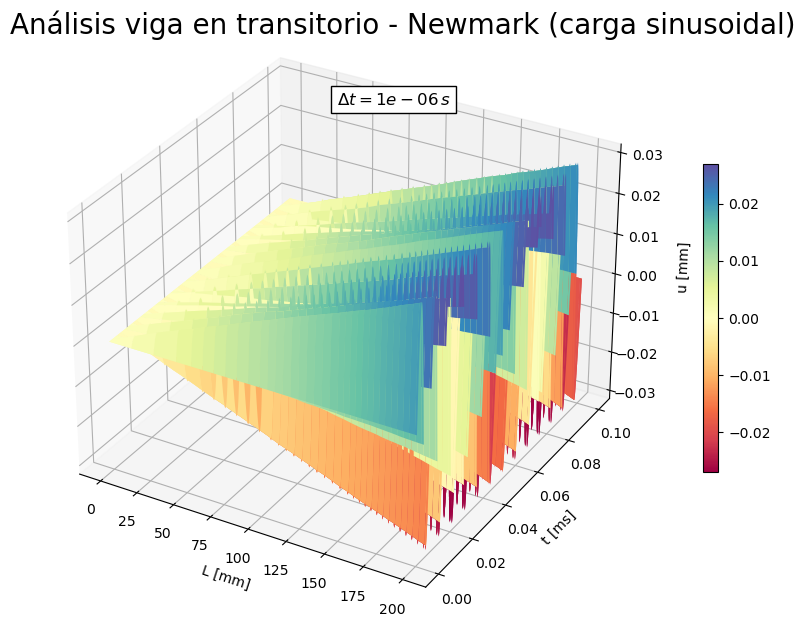

In [35]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')

# Graficar la superficie
X_grid, Y_grid = np.meshgrid(X, tiemposNM6)
ax.plot_surface(X_grid, Y_grid, desplazNM6[:, :, 0], cmap='Spectral', edgecolor='none')

# Título y ejes
plt.title('Análisis viga en transitorio - Newmark (carga sinusoidal)', fontsize=20, x=0.6, y=1.03)
ax.set_xlabel('L [mm]')
ax.set_ylabel('t [ms]')
ax.set_zlabel('\nu [mm]', linespacing=2)

ax.text(150, 0, 0.07, f'$\\Delta t = {deltaTNM6:.2g} \,  s$', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

# Barra de color
plt.colorbar(ax.plot_surface(X_grid, Y_grid, desplazNM6[:, :, 0], cmap='Spectral', edgecolor='none'), shrink = 0.5)
plt.subplots_adjust(right=1.2)

plt.show()

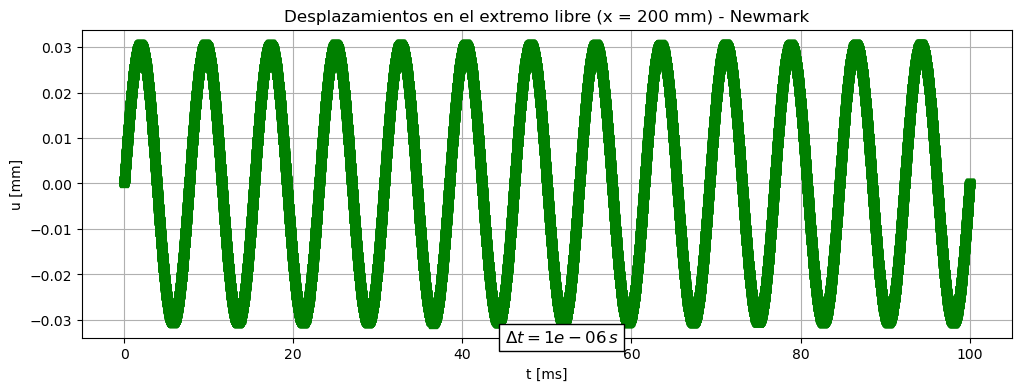

In [36]:
plt.figure(figsize=(12,4))

plt.plot(tiemposNM6[:int(100e-3/deltaTNM6)]*1000, desplazNM6[:int(100e-3/deltaTNM6), -1, 0], marker='s', c='g')

plt.title('Desplazamientos en el extremo libre (x = 200 mm) - Newmark')
plt.xlabel('t [ms]')
plt.ylabel('u [mm]')
plt.grid(True)
plt.text(45, -0.035, f'$\\Delta t = {deltaTNM6:.2g} \,  s$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.show()

Se nota en este caso que los desplazamiento ya no son únicamente positivos. El carácter de los mismos describe claramente una función senoidal, como es de esperarse.

## Continuación - Convección, Difusión e Incompresibles

Se tiene al siguiente elemento:

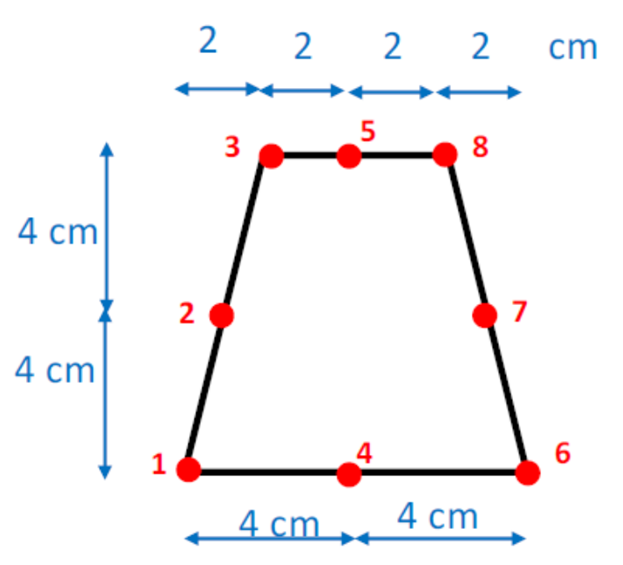

En primer lugar se definen las funciones de forma. Dado que el orden de numeración de los nodos no sigue la nomenclatura convencional propuesta, por ejemplo por Bathe, hay que analizar la posición de cada nodo para aplicar las expresiones indicadas en la bilbiografía:

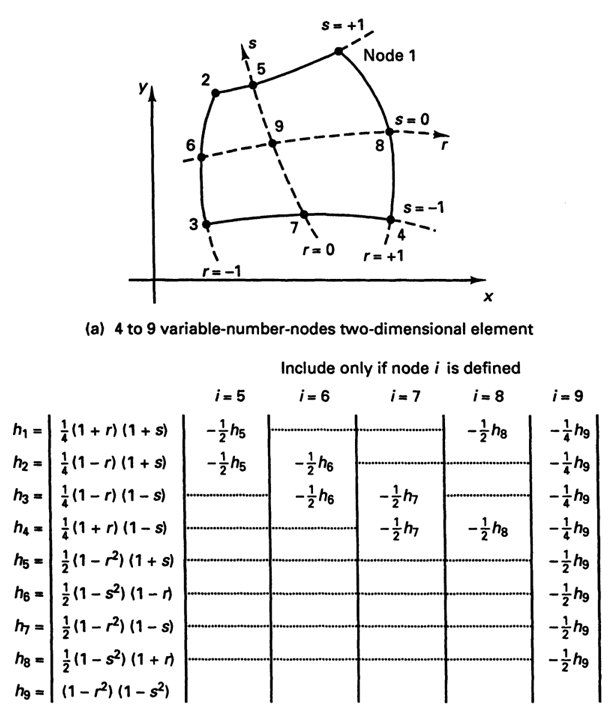

Las funciones de forma quedan entonces:

$$
h_1 (r, s) = \frac{1}{4} \, \left (1 - r \right)\left(1 - s \right) - \frac{1}{2} \, h_2 - \frac{1}{2} \, h_4 \\[3pt]
h_2 (r, s) = \frac{1}{2} \, \left (1 - s^2 \right)\left(1 - r \right) \\[3pt]
h_3 (r, s) = \frac{1}{4} \, \left (1 - r \right)\left(1 + s \right) - \frac{1}{2} \, h_5 - \frac{1}{2} \, h_2 \\[3pt]
h_4 (r, s) = \frac{1}{2} \, \left (1 - r^2 \right)\left(1 - s \right) \\[3pt]
h_5 (r, s) = \frac{1}{2} \, \left (1 - r^2 \right)\left(1 + s \right) \\[3pt]
h_6 (r, s) = \frac{1}{4} \, \left (1 + r \right)\left(1 - s \right) - \frac{1}{2} \, h_4 - \frac{1}{2} \, h_7 \\[3pt]
h_7 (r, s) = \frac{1}{2} \, \left (1 - s^2 \right)\left(1 + r \right) \\[3pt]
h_8 (r, s) = \frac{1}{4} \, \left (1 + r \right)\left(1 + s \right) - \frac{1}{2} \, h_5 - \frac{1}{2} \, h_7
$$

La definición en el código no puede seguir este mismo orden debido a la dependencia de una función de otra. Una vez definidas, se almacenan todas en una matriz `H_elem`.

Vale aclarar que se usa matemática simbólica a modo de poder visualizar el orden de los polinomios que quedan y justificar la cantidad de puntos de Gauss que se emplearán al integrar. Además resulta más didáctico ver en dónde se encuentra cada variable (incluso si las expresiones no son muy amigables). Está fuera de discusión que el costo computacional de este procedimiento es más alto y resulta prácticamente inaplicable a programas más complejos, pero por la simplicidad que implica calcular parámetros para un solo elemento y su carácter didáctico, se lo elige para lo que queda del Trabajo.

In [37]:
# Definición de variables
r, s = smp.symbols('r s', real=True)

# Funciones de forma
h_7 = smp.Rational(1,2)*(1 - s**2)*(1 + r)
h_4 = smp.Rational(1,2)*(1 - r**2)*(1 - s)
h_2 = smp.Rational(1,2)*(1 - s**2)*(1 - r)
h_5 = smp.Rational(1,2)*(1 - r**2)*(1 + s)
h_6 = smp.Rational(1,4)*(1 + r)*(1 - s) - smp.Rational(1,2)*h_4 - smp.Rational(1,2)*h_7
h_1 = smp.Rational(1,4)*(1 - r)*(1 - s) - smp.Rational(1,2)*h_2 - smp.Rational(1,2)*h_4
h_3 = smp.Rational(1,4)*(1 - r)*(1 + s) - smp.Rational(1,2)*h_5 - smp.Rational(1,2)*h_2
h_8 = smp.Rational(1,4)*(1 + r)*(1 + s) - smp.Rational(1,2)*h_5 - smp.Rational(1,2)*h_7

# Matriz de funciones de interpolación
H_elem = smp.Matrix([h_1, h_2, h_3, h_4, h_5, h_6, h_7, h_8])

Una verificación que se puede hacer es chequear que en cada nodo valga $1$ la función correspondiente y $0$ las demás. Se puede lograr rápidamente definiendo las coordenadas de cada nodo y evaluando las funciones mediante un bucle:

In [38]:
# Coordenadas locales de cada nodo
coord_nodos = [
    [(r, -1), (s, -1)],
    [(r, -1), (s, 0)],
    [(r, -1), (s, 1)],
    [(r, 0), (s, -1)],
    [(r, 0), (s, 1)],
    [(r, 1), (s, -1)],
    [(r, 1), (s, 0)],
    [(r, 1), (s, 1)]
]

verificacion_nodos = [[] for _ in range(8)]

# Evaluación en cada nodo
for funcion in range (8):
    verificacion_nodos[funcion] = [H_elem[funcion].subs(subs) for subs in coord_nodos]

for f_interp in verificacion_nodos:
    print(f_interp)

[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 1]


Se ve que se obtiene una "matriz identidad", por lo que la verificación es satisfactoria.

Tambien debe verificarse que la suma de las funciones de interpolación sea igual a $1$:

In [39]:
smp.Add(*H_elem).simplify()

1

Se ve que se verifica entonces la definición de las funciones de interpolación para este elemento. Adicionalmente se pueden plotear los puntos y verificar representando su número de índice para una mejor confirmación:

In [40]:
# Coordenadas globales de cada nodo
X_i_1 = smp.Matrix([0, 1, 2, 4, 4, 8, 7, 6])
Y_i_1 = smp.Matrix([0, 4, 8, 0, 8, 0, 4, 8])

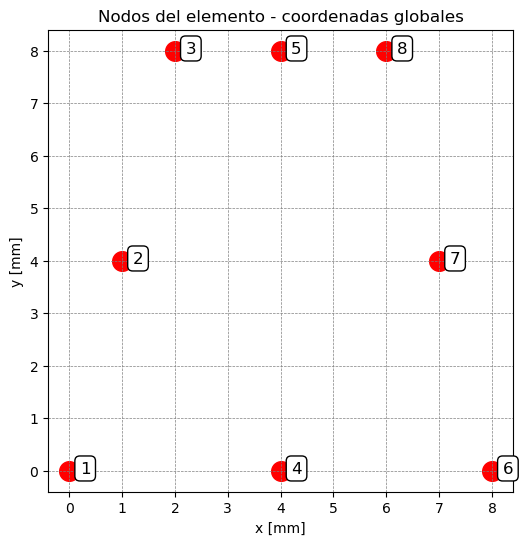

In [41]:
plt.figure(figsize=(6,6))
plt.scatter(X_i_1, Y_i_1, color='red', s=200)

for i, (x, y) in enumerate(zip(X_i_1, Y_i_1)):
    plt.text(x + 0.2, y-0.1, str(i+1), ha='left', va='bottom', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('Nodos del elemento - coordenadas globales')
plt.grid(which='both', axis='both', color='gray', linestyle='--', linewidth=0.5)
plt.xticks(range(0, 9))
plt.yticks(range(0, 9))
plt.show()

### Matriz $\underline{\underline{N}}^G$

La expresión de la matriz buscada es

$$
\underline{\underline{N}}^{G \, (e)} = \int^{1}_{-1} \int^{1}_{-1} \int^{1}_{-1} h^{(e)} \, \underline{\mathrm{v}} \cdot \underline{\nabla}h^{(e)} \, |J^{(e)}| \, \mathrm{d}r \, \mathrm{d}s \, \mathrm{d}t 
$$

- $h$ corresponde al vector con las funciones de interpolación. Esto ya se calculó y se almacenó como `H_elem`.

- $\underline{\mathrm{v}}$ es la velocidad del elemento y es dato: $\underline{\mathrm{v}} = \begin{bmatrix} 2 & 2 \end{bmatrix} cm/s$.

- $\underline{\nabla}h^{(e)}$ es el gradiente de las funciones de interpolación. Para calcularlo se requiere el jacobiano $\underline{\underline{J^{(e)}}}$.

- $|J^{(e)}|$ es el determinante del jacobiano.

Es trivial entonces que lo primer a calcular es el jacobiano $\underline{\underline{J}}^{(e)}$, que se se obtiene como:

$$
\underline{\underline{J}}^{(e)} = 
\left[
\begin{array}{cc}
\displaystyle \frac{\partial x}{\partial r} & \displaystyle \frac{\partial y}{\partial r} \\
\\
\displaystyle \frac{\partial x}{\partial s} & \displaystyle \frac{\partial y}{\partial s}
\end{array}
\right]
$$

donde 

$$\frac{\partial x}{\partial r} = \sum_{i=1}^{4} \frac{\partial h_i}{\partial r} \, \hat{X}_i $$
$$\frac{\partial x}{\partial s} = \sum_{i=1}^{4} \frac{\partial h_i}{\partial s} \, \hat{X}_i $$
$$\frac{\partial y}{\partial r} = \sum_{i=1}^{4} \frac{\partial h_i}{\partial r} \, \hat{Y}_i $$
$$\frac{\partial y}{\partial s} = \sum_{i=1}^{4} \frac{\partial h_i}{\partial s} \, \hat{Y}_i $$

Una vez definidas 2 variables `H_r` y `H_s` como vectores que contienen las derivadas de las funciones de interpolación, se obtiene el jacobiano:

In [42]:
# Derivadas de funciones de interpolación
H_r = H_elem.T.diff(r)
H_s = H_elem.T.diff(s)

# Matriz de derivadas
H_der = smp.Matrix([[H_r], [H_s]])

# Jacobiano
J_1 = smp.zeros(2, 2)

for i in range(8):
    J_1[0 , 0] += H_r[i] * X_i_1[i]
    J_1[0 , 1] += H_r[i] * Y_i_1[i]
    J_1[1 , 0] += H_s[i] * X_i_1[i]
    J_1[1 , 1] += H_s[i] * Y_i_1[i]

In [43]:
from IPython.display import Markdown as md

display(md(f'$$\\underline{{\\underline{{J}}}}^{{(e)}} = {smp.latex(J_1)}$$'))

$$\underline{\underline{J}}^{(e)} = \left[\begin{matrix}3 - s & 0\\- r & 4\end{matrix}\right]$$

Será necesario obtener su determinante e inversa:

In [44]:
det_J_1 = smp.det(J_1)
inv_J_1 = J_1.inv()

In [45]:
display(md(f'$$|J^{{(e)}}| = {smp.latex(det_J_1)}$$'))
display(md(f'$${{\\underline{{\\underline{{J}}}}^{{(e)}}}}^{{-1}} = {smp.latex(inv_J_1)}$$'))

$$|J^{(e)}| = 12 - 4 s$$

$${\underline{\underline{J}}^{(e)}}^{-1} = \left[\begin{matrix}\frac{1}{3 - s} & 0\\\frac{r}{12 - 4 s} & \frac{1}{4}\end{matrix}\right]$$

Con la inversa de $\underline{\underline{J}}^{(e)}$ se calcula la matriz de derivadas respecto a coordenadas globales $\underline{\nabla}h^{(e)}$:

$$\underline{\nabla}h^{(e)} = \begin{bmatrix}
\frac{\partial h_{1}}{\partial x} &  \frac{\partial h_{2}}{\partial x}&  \frac{\partial h_{3}}{\partial x}&  \frac{\partial h_{4}}{\partial x}&  \frac{\partial h_{5}}{\partial x}&  \frac{\partial h_{6}}{\partial x}&  \frac{\partial h_{7}}{\partial x}&  \frac{\partial h_{8}}{\partial x}\\[ 10pt]
\frac{\partial h_{1}}{\partial y} &  \frac{\partial h_{2}}{\partial y}&  \frac{\partial h_{3}}{\partial y}&  \frac{\partial h_{4}}{\partial y}&  \frac{\partial h_{5}}{\partial y}&  \frac{\partial h_{6}}{\partial y}&  \frac{\partial h_{7}}{\partial y}&  \frac{\partial h_{8}}{\partial y}
\end{bmatrix}
$$

$$
\underline{\nabla}h^{(e)} = \left [\underline{\underline{J}}^{(e)} \right]^{-1} \cdot \underline{\underline{H_{rs}}}
$$

siendo 

$$
\underline{\underline{H_{rs}}} = \begin{bmatrix}
\frac{\partial h_{1}}{\partial r} &  \frac{\partial h_{2}}{\partial r}&  \frac{\partial h_{3}}{\partial r}&  \frac{\partial h_{4}}{\partial r}&  \frac{\partial h_{5}}{\partial r}&  \frac{\partial h_{6}}{\partial r}&  \frac{\partial h_{7}}{\partial r}&  \frac{\partial h_{8}}{\partial r}\\[ 10pt]
\frac{\partial h_{1}}{\partial s} &  \frac{\partial h_{2}}{\partial s}&  \frac{\partial h_{3}}{\partial s}&  \frac{\partial h_{4}}{\partial s}&  \frac{\partial h_{5}}{\partial s}&  \frac{\partial h_{6}}{\partial s}&  \frac{\partial h_{7}}{\partial s}&  \frac{\partial h_{8}}{\partial s}
\end{bmatrix}
$$

In [46]:
grad_h = inv_J_1*H_der

In [47]:
display(md(f'$$\\underline{{\\nabla}}h^{{(e)}} = {smp.latex(grad_h)}$$'))

$$\underline{\nabla}h^{(e)} = \left[\begin{matrix}\frac{\frac{r \left(1 - s\right)}{2} - \frac{s^{2}}{4} + \frac{s}{4}}{3 - s} & \frac{\frac{s^{2}}{2} - \frac{1}{2}}{3 - s} & \frac{\frac{r \left(s + 1\right)}{2} - \frac{s^{2}}{4} - \frac{s}{4}}{3 - s} & - \frac{r \left(1 - s\right)}{3 - s} & - \frac{r \left(s + 1\right)}{3 - s} & \frac{\frac{r \left(1 - s\right)}{2} + \frac{s^{2}}{4} - \frac{s}{4}}{3 - s} & \frac{\frac{1}{2} - \frac{s^{2}}{2}}{3 - s} & \frac{\frac{r \left(s + 1\right)}{2} + \frac{s^{2}}{4} + \frac{s}{4}}{3 - s}\\- \frac{r^{2}}{16} + \frac{r}{16} + \frac{r \left(\frac{r \left(1 - s\right)}{2} - \frac{s^{2}}{4} + \frac{s}{4}\right)}{12 - 4 s} + \frac{s \left(1 - r\right)}{8} & \frac{r \left(\frac{s^{2}}{2} - \frac{1}{2}\right)}{12 - 4 s} - \frac{s \left(1 - r\right)}{4} & \frac{r^{2}}{16} - \frac{r}{16} + \frac{r \left(\frac{r \left(s + 1\right)}{2} - \frac{s^{2}}{4} - \frac{s}{4}\right)}{12 - 4 s} + \frac{s \left(1 - r\right)}{8} & - \frac{r^{2} \cdot \left(1 - s\right)}{12 - 4 s} + \frac{r^{2}}{8} - \frac{1}{8} & - \frac{r^{2}}{8} - \frac{r^{2} \left(s + 1\right)}{12 - 4 s} + \frac{1}{8} & - \frac{r^{2}}{16} - \frac{r}{16} + \frac{r \left(\frac{r \left(1 - s\right)}{2} + \frac{s^{2}}{4} - \frac{s}{4}\right)}{12 - 4 s} + \frac{s \left(r + 1\right)}{8} & \frac{r \left(\frac{1}{2} - \frac{s^{2}}{2}\right)}{12 - 4 s} - \frac{s \left(r + 1\right)}{4} & \frac{r^{2}}{16} + \frac{r}{16} + \frac{r \left(\frac{r \left(s + 1\right)}{2} + \frac{s^{2}}{4} + \frac{s}{4}\right)}{12 - 4 s} + \frac{s \left(r + 1\right)}{8}\end{matrix}\right]$$

Se ve que la expresión es bastante engorrosa pero se la presenta igualmente. 

Se define el vector de velocidades:

In [48]:
# Vector velocidad
velocidad = smp.Matrix([[2, 2]])

Con los parámetros necesarios calculados, resta realizar la integración para obtener la matriz $\underline{\underline{N}}^G$.

Se ve que multiplicando los componentes del integrando, para uno de los elementos se obtiene:

In [49]:
display(md(f'$$h^{{(e)}} \, \\underline{{\\mathrm{{v}}}} \\cdot \\underline{{\\nabla}}h^{{(e)}} \\, |J^{{(e)}}| = {smp.latex((H_elem*velocidad*grad_h*det_J_1)[0, 1].simplify())}$$'))

$$h^{(e)} \, \underline{\mathrm{v}} \cdot \underline{\nabla}h^{(e)} \, |J^{(e)}| = \frac{\left(- \left(1 - r\right) \left(1 - s\right) + \left(1 - r\right) \left(1 - s^{2}\right) + \left(1 - r^{2}\right) \left(1 - s\right)\right) \left(- r \left(s^{2} - 1\right) - 4 s^{2} + 2 s \left(r - 1\right) \left(s - 3\right) + 4\right)}{4}$$

Viendo entonces que hay polinimios de grado 6, se opta por utilizar 4 puntos de Gauss ya que el orden máximo del polinomio es $2 \times N_{PG} - 1$ y con 4 puntos se integra hasta orden 7. En las matrices que se calculan integrando de aquí en adelante se asume un espesor unitario. Esto se traduce por integrar únicamente en las 2 coordenadas del elemento.

In [50]:
# Inicialización NG
matriz_NG = smp.zeros(8,8)

# Puntos y pesos de Gauss para N = 4
PG_4 = [np.sqrt((3-2*np.sqrt(6/5))/7), -np.sqrt((3-2*np.sqrt(6/5))/7), np.sqrt((3+2*np.sqrt(6/5))/7), -np.sqrt((3+2*np.sqrt(6/5))/7)]
OmegaG_4 = [(18+np.sqrt(30))/36, (18+np.sqrt(30))/36, (18-np.sqrt(30))/36, (18-np.sqrt(30))/36]

for i in range (len(PG_4)):
    sG = PG_4[i]
    for j in range (len(PG_4)):
        rG = PG_4[j]
        matriz_NG += (OmegaG_4[i]*(OmegaG_4[j]*(H_elem*velocidad*grad_h*det_J_1))).subs([(r, rG), (s, sG)])

In [51]:
display(md(f'$$\\underline{{\\underline{{N}}}}^G = {smp.latex(matriz_NG.evalf(4))}$$'))

$$\underline{\underline{N}}^G = \left[\begin{matrix}-1.867 & 2.711 & -0.3333 & 2.578 & -0.7111 & -0.4444 & -1.467 & -0.4667\\-3.511 & -3.2 & -0.8444 & 4.996 \cdot 10^{-16} & 5.333 & -1.022 & 4.267 & -1.022\\0.7333 & 0.04444 & -0.2667 & 1.156 & 0.7111 & -0.06667 & -1.467 & -0.8444\\-3.644 & -3.331 \cdot 10^{-16} & -1.156 & -4.267 & 3.2 & -0.08889 & 7.111 & -1.156\\0.7111 & -5.333 & -0.1778 & -3.2 & 2.133 & 0.7111 & 1.778 & 3.378\\0.9778 & 1.022 & 0.06667 & -0.9778 & -0.7111 & 0.2667 & 0.2222 & -0.8667\\1.467 & -4.267 & 1.467 & -7.111 & -1.778 & 1.111 & 5.333 & 3.778\\0.4667 & 1.022 & 0.5778 & 1.156 & -2.844 & 0.2 & -2.444 & 1.867\end{matrix}\right]$$

La matriz no es simétrica por lo que no hay muchas verificaciones por hacer. Sí se puede resaltar que por cuestiones numéricas algunos elementos dan muy cercanos a $0$, en el orden de $10^{-16}$. Esto no debería ser un problema porque los demás valores no superan la decena. Podría ser conveniente redondear ambos a $0$ para futuros cálculos.

### Matriz $\underline{\underline{N}}^P$

La matriz de Petrov - Galerkin tiene una expresión similar:

$$
\underline{\underline{N}}^{P \, (e)} = \int^{1}_{-1} \int^{1}_{-1} \int^{1}_{-1} W^{(e)} \, \underline{\mathrm{v}} \cdot \underline{\nabla}h^{(e)} \, |J^{(e)}| \, \mathrm{d}r \, \mathrm{d}s \, \mathrm{d}t 
$$

En este caso se pondera con $h_{i} + W_{i}$ y se interpola con $h_{i}$. La función de peso no está definida en los nodos y surge de:

$$W_i = \tau \cdot \underline{\mathrm{v}} \cdot \underline{\nabla} h_{i}$$



donde $\tau$ es el tiempo intrínseco y se calcula como:

$$ \tau = \sum_{i=1}^{N} \frac{\alpha_{i} \, v_{i}^{C} \, l_{i}}{2} \, \frac {1}{|| \underline{\mathrm{v}}||^{2}} $$

$$ \alpha_{i} = coth |\mathrm{Pe}_{i}| - \frac{1}{|\mathrm{Pe}_{i}|} $$

$$ \mathrm{Pe}_{i} = \frac{v_{i} \, l_{i}}{2 \, k} $$

$$ ||\underline{\mathrm{v}}|| = \left [\sum_{i=1}^{N} v_{i}^{2} \right ]^{1/2} $$

siendo $N$ el número de dimensión del espacio, en este caso 2.



Se procede a calcular cada una de las variables:

$$ ||\underline{\mathrm{v}}|| = \left [\sum_{i=1}^{N} v_{i}^{2} \right ]^{1/2} = \left [(2 \, cm/s)^2 + (2 \, cm/s)^2 \right ]^{1/2} = \sqrt{8} \, cm/s \\[20pt]$$

$$ \mathrm{Pe}_{1} = \frac{v_{1} \, l_{1}}{2 \, k} = \frac{2 \, cm/s \cdot 6 \, cm}{2 \cdot 0.001 \, cm^{2}/s} = 6000$$

$$ \mathrm{Pe}_{2} = \frac{v_{2} \, l_{2}}{2 \, k} = \frac{2 \, cm/s \cdot 8 \, cm}{2 \cdot 0.001 \, cm^{2}/s} = 8000 \\[20pt]$$

$$ \alpha_{1} = coth |\mathrm{Pe}_{1}| - \frac{1}{|\mathrm{Pe}_{1}|} = coth \, 6000 - \frac{1}{6000} = 1 - \frac{1}{6000} = 999.833 \times 10^{-3}$$

$$ \alpha_{2} = coth |\mathrm{Pe}_{2}| - \frac{1}{|\mathrm{Pe}_{2}|} = coth \, 8000 - \frac{1}{6000} = 1 - \frac{1}{8000} = 999.875 \times 10^{-3} \\[20pt]$$

$$ \tau = \sum_{i=1}^{N} \frac{\alpha_{i} \, v_{i}^{C} \, l_{i}}{2} \, \frac {1}{|| \underline{\mathrm{v}}||^{2}} = \frac{\alpha_{1} \, v_{1}^{C} \, l_{1}}{2} \, \frac {1}{|| \underline{\mathrm{v}}||^{2}} + \frac{\alpha_{2} \, v_{2}^{C} \, l_{2}}{2} \, \frac {1}{|| \underline{\mathrm{v}}||^{2}}$$

$$ \tau = \frac{999.833 \times 10^{-3} \cdot 2 \, cm/s \cdot 6 \, cm}{2} \, \frac {1}{\left (\sqrt{8} \, cm/s \right)^{2} \, cm/s} + \frac{999.875 \times 10^{-3} \cdot 2 \, cm/s \cdot 8 \, cm}{2} \, \frac {1}{\left (\sqrt{8} \, cm/s \right)^{2}}$$

$$ \tau = 1,75 \, s$$


Se calcula ahora $W^{(e)}$. Como se multiplica un escalar por la velocidad (1x2) por la matriz definida antes $\underline{\nabla}h^{(e)}$ (2x8) esta variable será de 1x8.

In [52]:
tau = 1.75 # s

W_i = tau * velocidad * grad_h

W_i.shape

(1, 8)

In [53]:
display(md(f'$$W^{{(e)}} = {smp.latex(W_i.evalf(3))}$$'))

$$W^{(e)} = \left[\begin{matrix}- 0.219 r^{2} + 0.219 r + \frac{3.5 r \left(0.5 r \left(1.0 - s\right) - 0.25 s^{2} + 0.25 s\right)}{12.0 - 4.0 s} + 0.438 s \left(1.0 - r\right) + \frac{3.5 \cdot \left(0.5 r \left(1.0 - s\right) - 0.25 s^{2} + 0.25 s\right)}{3.0 - s} & \frac{3.5 r \left(0.5 s^{2} - 0.5\right)}{12.0 - 4.0 s} - 0.875 s \left(1.0 - r\right) + \frac{3.5 \cdot \left(0.5 s^{2} - 0.5\right)}{3.0 - s} & 0.219 r^{2} - 0.219 r + \frac{3.5 r \left(0.5 r \left(s + 1.0\right) - 0.25 s^{2} - 0.25 s\right)}{12.0 - 4.0 s} + 0.438 s \left(1.0 - r\right) + \frac{3.5 \cdot \left(0.5 r \left(s + 1.0\right) - 0.25 s^{2} - 0.25 s\right)}{3.0 - s} & - \frac{3.5 r^{2} \cdot \left(1.0 - s\right)}{12.0 - 4.0 s} + 0.438 r^{2} - \frac{3.5 r \left(1.0 - s\right)}{3.0 - s} - 0.438 & - 0.438 r^{2} - \frac{3.5 r^{2} \left(s + 1.0\right)}{12.0 - 4.0 s} - \frac{3.5 r \left(s + 1.0\right)}{3.0 - s} + 0.438 & - 0.219 r^{2} - 0.219 r + \frac{3.5 r \left(0.5 r \left(1.0 - s\right) + 0.25 s^{2} - 0.25 s\right)}{12.0 - 4.0 s} + 0.438 s \left(r + 1.0\right) + \frac{3.5 \cdot \left(0.5 r \left(1.0 - s\right) + 0.25 s^{2} - 0.25 s\right)}{3.0 - s} & \frac{3.5 r \left(0.5 - 0.5 s^{2}\right)}{12.0 - 4.0 s} - 0.875 s \left(r + 1.0\right) + \frac{3.5 \cdot \left(0.5 - 0.5 s^{2}\right)}{3.0 - s} & 0.219 r^{2} + 0.219 r + \frac{3.5 r \left(0.5 r \left(s + 1.0\right) + 0.25 s^{2} + 0.25 s\right)}{12.0 - 4.0 s} + 0.438 s \left(r + 1.0\right) + \frac{3.5 \cdot \left(0.5 r \left(s + 1.0\right) + 0.25 s^{2} + 0.25 s\right)}{3.0 - s}\end{matrix}\right]$$

Inicializamos la matriz y calculamos sus elementos mediante un bucle análogo al de la matriz $\underline{\underline{N}}^G$:

In [54]:
matriz_NP = smp.zeros(8,8)

for i in range (len(PG_4)):
    sG = PG_4[i]
    for j in range (len(PG_4)):
        rG = PG_4[j]
        matriz_NP += (OmegaG_4[i]*(OmegaG_4[j]*(W_i.T*velocidad*grad_h*det_J_1))).subs([(r, rG)]).subs([(s, sG)])

In [55]:
display(md(f'$$\\underline{{\\underline{{N}}}}^P = {smp.latex(matriz_NP.evalf(5))}$$'))

$$\underline{\underline{N}}^P = \left[\begin{matrix}12.953 & -8.3211 & 3.5015 & -8.5338 & -6.577 & 3.261 & -2.9566 & 6.6726\\-8.3211 & 14.498 & -1.7991 & 6.6438 & -2.3988 & -1.8227 & -0.49792 & -6.3022\\3.5015 & -1.7991 & 2.6469 & -2.9316 & -6.5813 & 1.0828 & -0.92316 & 5.0039\\-8.5338 & 6.6438 & -2.9316 & 18.696 & 6.0085 & -3.9398 & -9.7549 & -6.1881\\-6.577 & -2.3988 & -6.5813 & 6.0085 & 22.983 & -3.3205 & 5.5099 & -15.624\\3.261 & -1.8227 & 1.0828 & -3.9398 & -3.3205 & 1.3593 & -0.12175 & 3.5015\\-2.9566 & -0.49792 & -0.92316 & -9.7549 & 5.5099 & -0.12175 & 14.498 & -5.7534\\6.6726 & -6.3022 & 5.0039 & -6.1881 & -15.624 & 3.5015 & -5.7534 & 18.689\end{matrix}\right]$$

Se sabe que la matriz convectiva tiene que ser simétrica en este caso y así resulta. Llama la atención que uno de los valores de la diagonal está en el orden de $10^{-15}$ mientras que los otros en el orden de $10^{1}$, esto podría ocasionar inestabilidades y problemas de índole numérica debido a la gran diferencia.

### Matriz $\underline{\underline{K}}_{vp}$

La matriz, para un elemento, se calcula como :

$$
\underline{\underline{K}}_{vp} = \int^{1}_{-1} \int^{1}_{-1} \int^{1}_{-1} {\underline{B}^{(e)}}^{T} \cdot \underline{m} \cdot \underline{H}_{p}^{(e)} \, |J^{(e)}| \, \mathrm{d}r \, \mathrm{d}s \, \mathrm{d}t 
$$

En primer lugar se calcula ${\underline{B}^{(e)}}$. En este caso será de 4x16 ($4 \times 2 \, N_{nodos}$) y tendrá la forma:

$${\underline{B}^{(e)}} = 
\begin{bmatrix}
\frac{\partial h_{1}}{\partial x} &  0&  \frac{\partial h_{2}}{\partial x}&  0&  \frac{\partial h_{3}}{\partial x}&  0&  \frac{\partial h_{4}}{\partial x}&  0&  \frac{\partial h_{5}}{\partial x}&  0&  \frac{\partial h_{6}}{\partial x}&  0&  \frac{\partial h_{7}}{\partial x}&  0&  \frac{\partial h_{8}}{\partial x}&  0\\[5pt]
 0&  \frac{\partial h_{1}}{\partial y}&  0&  \frac{\partial h_{2}}{\partial y}&  0&  \frac{\partial h_{3}}{\partial y}&  0&  \frac{\partial h_{4}}{\partial y}&  0&  \frac{\partial h_{5}}{\partial y}&  0&  \frac{\partial h_{6}}{\partial y}&  0&  \frac{\partial h_{8}}{\partial y}&  0&  \frac{\partial h_{1}}{\partial y}\\[5pt]
 \frac{\partial h_{1}}{\partial y}&  \frac{\partial h_{1}}{\partial x}&  \frac{\partial h_{2}}{\partial y}&  \frac{\partial h_{2}}{\partial x}&  \frac{\partial h_{3}}{\partial y}&  \frac{\partial h_{3}}{\partial xy}&  \frac{\partial h_{4}}{\partial y}&  \frac{\partial h_{4}}{\partial x}&  \frac{\partial h_{5}}{\partial y}&  \frac{\partial h_{5}}{\partial x}&  \frac{\partial h_{6}}{\partial y}&  \frac{\partial h_{6}}{\partial x}&  \frac{\partial h_{7}}{\partial y}&  \frac{\partial h_{7}}{\partial x}&  \frac{\partial h_{8}}{\partial y}& \frac{\partial h_{8}}{\partial x}\\[5 pt]
0 &  0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0& 0
\end{bmatrix}
$$

In [56]:
B_1_r = smp.zeros(4, 16)
H_i_r = H_elem.diff(r)
H_i_s = H_elem.diff(s)

# Cálculo y ensamble B
for i in range(8):
    h_x = H_i_r[i] * inv_J_1[0, 0] + H_i_s[i] * inv_J_1[0, 1]
    h_y = H_i_r[i] * inv_J_1[1, 0] + H_i_s[i] * inv_J_1[1, 1]

    B_1_r[0, 2*i] += h_x
    B_1_r[1, (2*i)+1] += h_y
    B_1_r[2, 2*i] += h_y
    B_1_r[2, (2*i)+1] += h_x

Si bien no se llega a apreciar completa por su complejidad algebráica, la matriz resulta:

In [57]:
display(md(f'$$\\underline{{B}}^{{(e)}} = {smp.latex(B_1_r)}$$'))

$$\underline{B}^{(e)} = \left[\begin{array}{cccccccccccccccc}\frac{\frac{r \left(1 - s\right)}{2} - \frac{s^{2}}{4} + \frac{s}{4}}{3 - s} & 0 & \frac{\frac{s^{2}}{2} - \frac{1}{2}}{3 - s} & 0 & \frac{\frac{r \left(s + 1\right)}{2} - \frac{s^{2}}{4} - \frac{s}{4}}{3 - s} & 0 & - \frac{r \left(1 - s\right)}{3 - s} & 0 & - \frac{r \left(s + 1\right)}{3 - s} & 0 & \frac{\frac{r \left(1 - s\right)}{2} + \frac{s^{2}}{4} - \frac{s}{4}}{3 - s} & 0 & \frac{\frac{1}{2} - \frac{s^{2}}{2}}{3 - s} & 0 & \frac{\frac{r \left(s + 1\right)}{2} + \frac{s^{2}}{4} + \frac{s}{4}}{3 - s} & 0\\0 & - \frac{r^{2}}{16} + \frac{r}{16} + \frac{r \left(\frac{r \left(1 - s\right)}{2} - \frac{s^{2}}{4} + \frac{s}{4}\right)}{12 - 4 s} + \frac{s \left(1 - r\right)}{8} & 0 & \frac{r \left(\frac{s^{2}}{2} - \frac{1}{2}\right)}{12 - 4 s} - \frac{s \left(1 - r\right)}{4} & 0 & \frac{r^{2}}{16} - \frac{r}{16} + \frac{r \left(\frac{r \left(s + 1\right)}{2} - \frac{s^{2}}{4} - \frac{s}{4}\right)}{12 - 4 s} + \frac{s \left(1 - r\right)}{8} & 0 & - \frac{r^{2} \cdot \left(1 - s\right)}{12 - 4 s} + \frac{r^{2}}{8} - \frac{1}{8} & 0 & - \frac{r^{2}}{8} - \frac{r^{2} \left(s + 1\right)}{12 - 4 s} + \frac{1}{8} & 0 & - \frac{r^{2}}{16} - \frac{r}{16} + \frac{r \left(\frac{r \left(1 - s\right)}{2} + \frac{s^{2}}{4} - \frac{s}{4}\right)}{12 - 4 s} + \frac{s \left(r + 1\right)}{8} & 0 & \frac{r \left(\frac{1}{2} - \frac{s^{2}}{2}\right)}{12 - 4 s} - \frac{s \left(r + 1\right)}{4} & 0 & \frac{r^{2}}{16} + \frac{r}{16} + \frac{r \left(\frac{r \left(s + 1\right)}{2} + \frac{s^{2}}{4} + \frac{s}{4}\right)}{12 - 4 s} + \frac{s \left(r + 1\right)}{8}\\- \frac{r^{2}}{16} + \frac{r}{16} + \frac{r \left(\frac{r \left(1 - s\right)}{2} - \frac{s^{2}}{4} + \frac{s}{4}\right)}{12 - 4 s} + \frac{s \left(1 - r\right)}{8} & \frac{\frac{r \left(1 - s\right)}{2} - \frac{s^{2}}{4} + \frac{s}{4}}{3 - s} & \frac{r \left(\frac{s^{2}}{2} - \frac{1}{2}\right)}{12 - 4 s} - \frac{s \left(1 - r\right)}{4} & \frac{\frac{s^{2}}{2} - \frac{1}{2}}{3 - s} & \frac{r^{2}}{16} - \frac{r}{16} + \frac{r \left(\frac{r \left(s + 1\right)}{2} - \frac{s^{2}}{4} - \frac{s}{4}\right)}{12 - 4 s} + \frac{s \left(1 - r\right)}{8} & \frac{\frac{r \left(s + 1\right)}{2} - \frac{s^{2}}{4} - \frac{s}{4}}{3 - s} & - \frac{r^{2} \cdot \left(1 - s\right)}{12 - 4 s} + \frac{r^{2}}{8} - \frac{1}{8} & - \frac{r \left(1 - s\right)}{3 - s} & - \frac{r^{2}}{8} - \frac{r^{2} \left(s + 1\right)}{12 - 4 s} + \frac{1}{8} & - \frac{r \left(s + 1\right)}{3 - s} & - \frac{r^{2}}{16} - \frac{r}{16} + \frac{r \left(\frac{r \left(1 - s\right)}{2} + \frac{s^{2}}{4} - \frac{s}{4}\right)}{12 - 4 s} + \frac{s \left(r + 1\right)}{8} & \frac{\frac{r \left(1 - s\right)}{2} + \frac{s^{2}}{4} - \frac{s}{4}}{3 - s} & \frac{r \left(\frac{1}{2} - \frac{s^{2}}{2}\right)}{12 - 4 s} - \frac{s \left(r + 1\right)}{4} & \frac{\frac{1}{2} - \frac{s^{2}}{2}}{3 - s} & \frac{r^{2}}{16} + \frac{r}{16} + \frac{r \left(\frac{r \left(s + 1\right)}{2} + \frac{s^{2}}{4} + \frac{s}{4}\right)}{12 - 4 s} + \frac{s \left(r + 1\right)}{8} & \frac{\frac{r \left(s + 1\right)}{2} + \frac{s^{2}}{4} + \frac{s}{4}}{3 - s}\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{array}\right]$$

En problemas 2D la matriz $\underline{m}$ tiene la forma

$$
\underline{m} = \begin{bmatrix}
1 \\
1 \\
0 \\
1
\end{bmatrix}
$$

In [58]:
matriz_m = smp.Matrix([1, 1, 0, 1])

La matriz $\underline{H}_{p}^{(e)}$ es de $1 \times N_p$ siendo $N_{p}$ la cantidad de nodos de presión. Por enunciado $N_{p} = 1$, como además la función es constante:

$$
\underline{H}_{p}^{(e)} = \left[ 1 \right]
$$

In [59]:
H_p = 1

Se procede a integrar como ya se viene haciendo:

In [60]:
matriz_Kvp = smp.zeros(16,1)

for i in range (len(PG_4)):
    sG = PG_4[i]
    for j in range (len(PG_4)):
        rG = PG_4[j]
        matriz_Kvp += OmegaG_4[j]*(B_1_r.T*matriz_m*H_p*det_J_1).subs([(r, rG)]).subs([(s, sG)])

In [61]:
display(md(f'$$\\underline{{\\underline{{K}}}}_{{vp}} = {smp.latex(matriz_Kvp.evalf(5))}$$'))

$$\underline{\underline{K}}_{vp} = \left[\begin{matrix}-3.4286\\-2.381\\-9.1429\\3.4286\\-3.4286\\1.619\\0\\-10.667\\0\\5.3333\\3.4286\\-2.381\\9.1429\\3.4286\\3.4286\\1.619\end{matrix}\right]$$

## Conclusiones

Se analizó el caso de una viga unidimensional sometida a una carga axial, primero constante y luego sinusoidal, tanto en el caso estático como en el transitorio. Se determinó el paso temporal más conveniente en base a un análisis más práctico de frecuencias principales. En este caso era más sencillo trabajar con autovalores para determinar las frecuencias pero se optó por seguir el enfoque de Bathe que puede terminar siendo más útil a la hora de resolver problemas más complejos. Se vio también cómo un paso más grande merma la definición de la señal cuyas frecuencias se analizan y trae como consecuencia un error mayor en la estimación del paso temporal crítico.

Adicionalmente se calcularon matrices convectivas mediante la formulación de Bubnov-Galerkin y Petrov-Galerkin trabajando con un elemento de una forma particular. También se analizó, para este mismo elemento, una parte de la matriz de rigidez de un fluido incompresible.

Se puede concluir que, si bien el análisis por el Método de los Elementos Finitos es una herramienta sumamente útil para simular estados de carga en sólidos para casos tanto estáticos como transitorios, es importante ser cuidadoso con los parámetros a considerar porque pueden obtenerse soluciones divergentes. Además, siempre habrá un compromiso entre costo computacional y precisión por lo que se debe tener en claro para qué se está realizando cada análisis a modo de elegir el camino óptimo.

In [62]:
from traitlets.config import Config
import nbformat as nbf
from nbconvert.exporters import HTMLExporter
from nbconvert.preprocessors import TagRemovePreprocessor

# Setup config
c = Config()

# Configure tag removal - be sure to tag your cells to remove  using the
# words remove_cell to remove cells. You can also modify the code to use
# a different tag word
c.TagRemovePreprocessor.remove_cell_tags = ("r_cell",)
c.TagRemovePreprocessor.remove_all_outputs_tags = ('r_output',)
c.TagRemovePreprocessor.remove_input_tags = ('r_input',)
c.TagRemovePreprocessor.enabled = True

# Configure and run out exporter
c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

exporter = HTMLExporter(config=c)
exporter.register_preprocessor(TagRemovePreprocessor(config=c),True)

# Configure and run our exporter - returns a tuple - first element with html,
# second with notebook metadata
output = HTMLExporter(config=c).from_filename("D:\Documentos\FIUBA\Cuadernos Jupyter\IMEF\TP4\IMEF - TP Final.ipynb")

# Write to output html file
with open("IMEF - TP Final.html",  "w") as f:
    f.write(output[0])